# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision



<font color='blue'>El objetivo de esta práctica es aprender a diseñar, implementar, entrenar y utilizar (es decir, aplicar en inferencia) redes neuronales convolucionales en tareas de visión por computador (clasificación y regresión en imágenes) usando fastai (https://docs.fast.ai/).

<font color='blue'>Se proporciona una guía de ayuda (`Assignment_2_HG.ipynb`) para, entre otras cosas, saber cómo:
1. realizar funciones básicas de lectura de datos, entrenamiento y optimización;
2. crear gráficos para la evolución del error de clasificación en
los conjuntos de entrenamiento y validación;
3. y calcular el error de clasificación en el conjunto de prueba.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Ejercicio 1: BaseNet en CIFAR100 (3 puntos)**

<font color='blue'>**Dataset:**
En este ejercicio, trabajaremos con parte del conjunto de datos CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos consta de $60000$ imágenes en color de $32\times32\times3$ (RGB) que representan 100 clases diferentes ($600$ imágenes por clase). Hay $50000$ imágenes para entrenamiento y $10000$ para test. No obstante, para el desarrollo del ejercicio solo consideraremos $25$ clases (de $100$). Por lo tanto, el conjunto de entrenamiento tendrá $12500$ imágenes y el conjunto de prueba $2500$ imágenes. Los alumnos deben emplear el $10\%$ del conjunto de entrenamiento para  validación.

<font color='blue'>**Modelo BaseNet:**
Comenzamos creando un modelo base llamado *BaseNet* que consta de dos bloques convolucionales (Conv+ReLU) separados por un proceso de *subsampling* (MaxPooling), y una cabeza compuesta por dos capas completamente conectadas (FC) (también llamadas capas densas). La arquitectura precisa se define en la siguiente tabla:

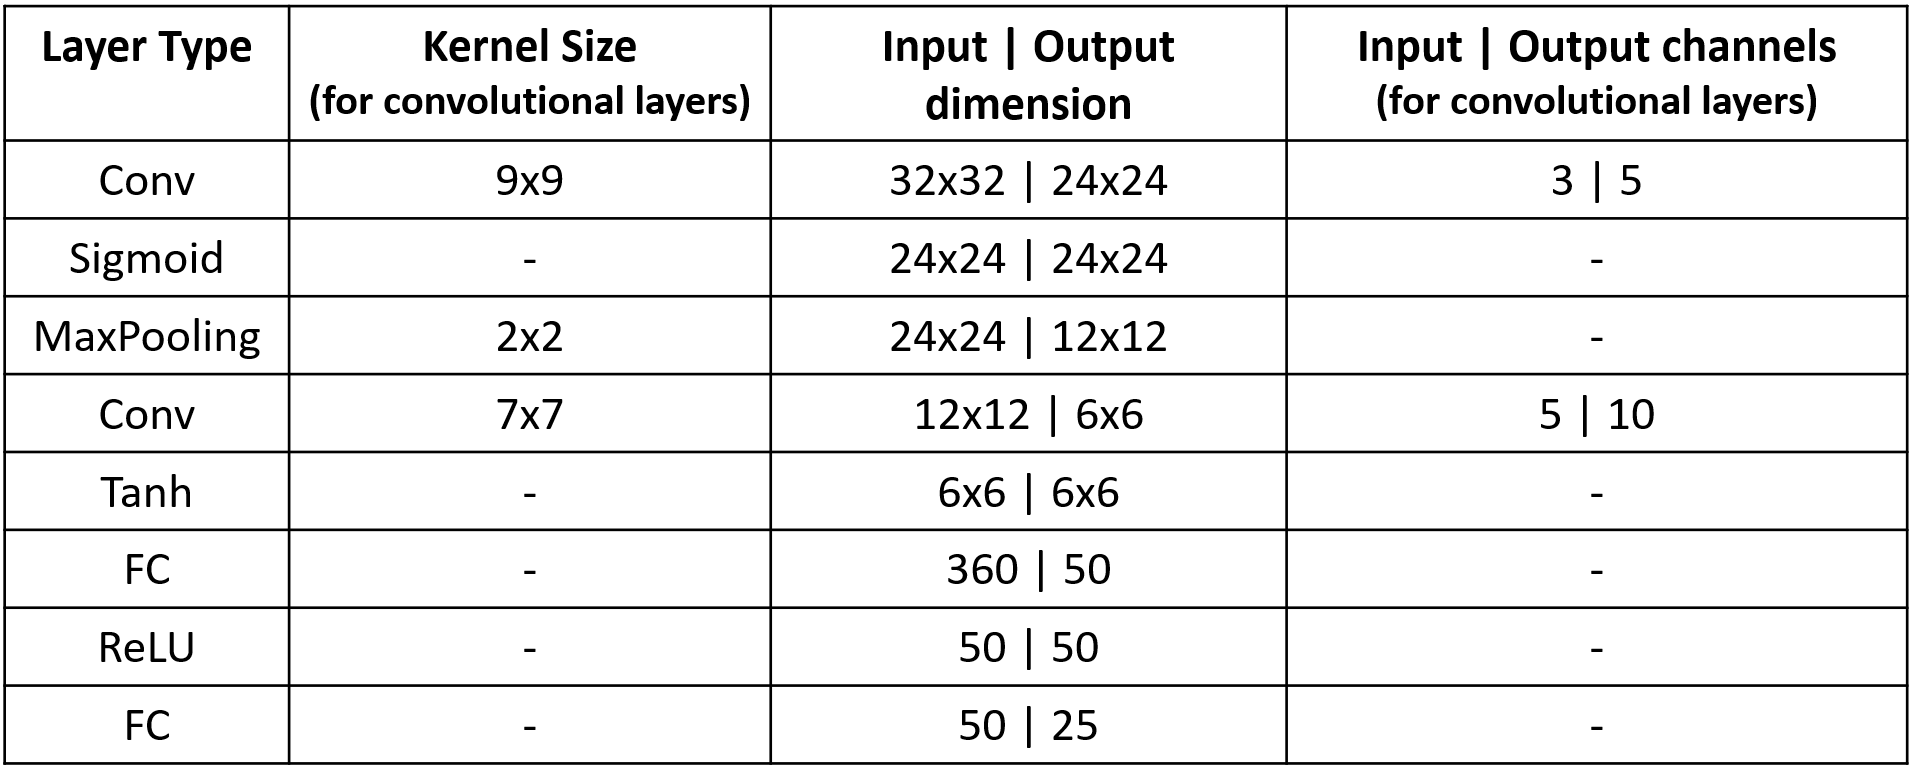

<font color='blue'>Los alumnos deben:
1. Crear el código para el modelo *BaseNet* empleando la librería fastai.
2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?
3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).
4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).



In [ ]:
from fastai.data.all import *
from fastai.vision.all import *
from fastai.metrics import F1Score

In [ ]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [ ]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train

Vemos que hay 20 clases, pero eso no debe confundirnos. Eso son solo las 20 superclases en que está subdividido el dataset. Véase https://github.com/fastai/dlcert2/blob/master/docs/datasets.md:
"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

In [ ]:
# Queremos verificar que dentro de cada una de las 20 superclases hay 5 clases,
# lo que da las 100 clases que hay. También queremos verificar que el número de imágenes
# es correcto
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Número de clases dentro de superclase ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/insects ):  [Path('/root/.fastai/data/cifar100/train/insects/cockroach'), Path('/root/.fastai/data/cifar100/train/insects/beetle'), Path('/root/.fastai/data/cifar100/train/insects/bee'), Path('/root/.fastai/data/cifar100/train/insects/butterfly'), Path('/root/.fastai/data/cifar100/train/insects/caterpillar')]
Número de clases dentro de superclase  0 :  5
Número de clases dentro de superclase  1 :  5
Número de clases dentro de superclase  2 :  5
Número de clases dentro de superclase  3 :  5
Número de clases dentro de superclase  4 :  5
Número de clases dentro de superclase  5 :  5
Número de clases dentro de superclase  6 :  5
Número de clases dentro de superclase  7 :  5
Número de clases dentro de superclase  8 :  5
Número de clases dentro de superclase  9 :  5
Número de clases dentro de superclase  10 :  5
Número de clases dentro de superclase  11 :  5
Número de clases dentro de superclase  12 :  5
Número de cla

Ahora nos quedamos con las primeras 25 clases. Lo que hacemos es eliminar las 75 últimas del dataset.

In [ ]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASES ELIMINADAS:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASES CONSERVADAS:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASES ELIMINADAS:
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/medium_mammals
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/trees
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/vehicles_2
SUPERCLASES CONSERVADAS:
/root/.fastai/data/cifar100/train/aquatic_mammals
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/food_container

In [ ]:
# También eliminamos las clases en test
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/insects
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/medium_mammals
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/people
/root/.fastai/data/cifar100/test/reptiles
/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/trees
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/vehicles_2


Ahora intentamos verificar si los hemos eliminado realmente.

In [ ]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Y que el número de ejemplos en training y test es el correcto.

In [ ]:
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/aquatic_mammals ):  [Path('/root/.fastai/data/cifar100/train/aquatic_mammals/dolphin'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals/seal'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals/beaver'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals/otter'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals/whale')]
Total training images:  12500
Total test images:  2500


Podemos observar que ahora tenemos el dataset tal y como nos interesa, con 12500 imágenes de entrenamiento y 2500 de test.

Ahora vamos a proceder a cargar los datos de entrenamiento. Para ello hacemos uso de DataLoaders y DataBlock.

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


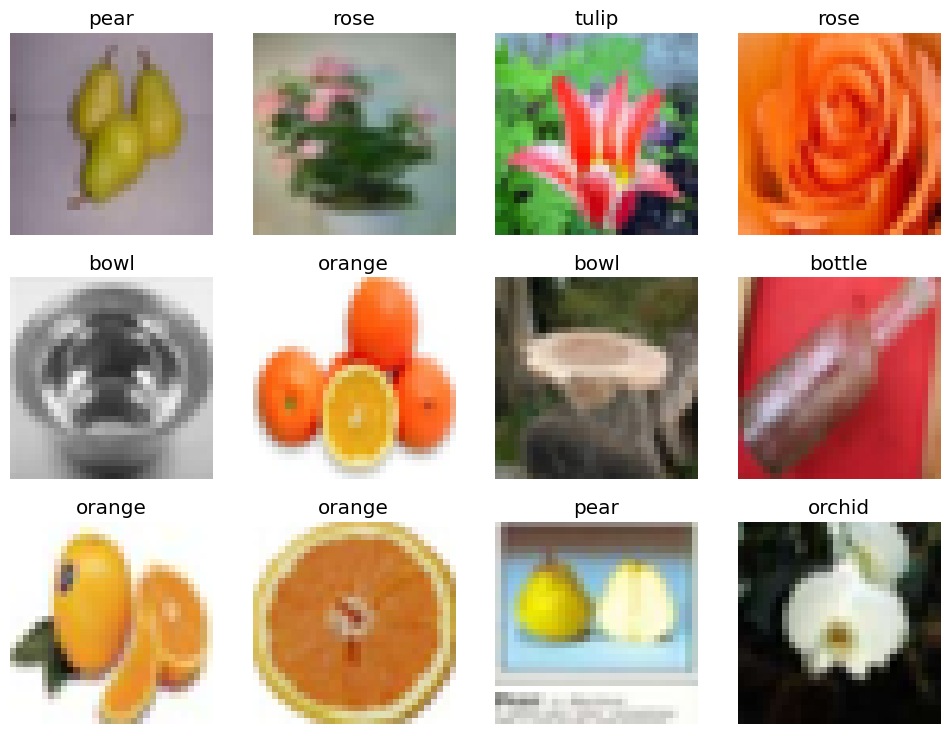

In [ ]:
# Definimos el DataBlock
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # las entradas son imágenes y las salidas categorías
    get_items=get_image_files,  # recuperar imágenes del path (imágenes del conjunto de entrenamiento)
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # separar un 10% del conjunto de entrenamiento para validación
    get_y=parent_label, # las etiquetas de las imágenes se obtienen del nombre del directorio en que se se encuentran
)

# Creamos los DataLoaders a partir del DataBlock
dl = db.dataloaders(path/'train')
#db.summary(path)

dl.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dl.train_ds))
print('Numero de ejemplos de validacion:', len(dl.valid_ds))

Example of training data


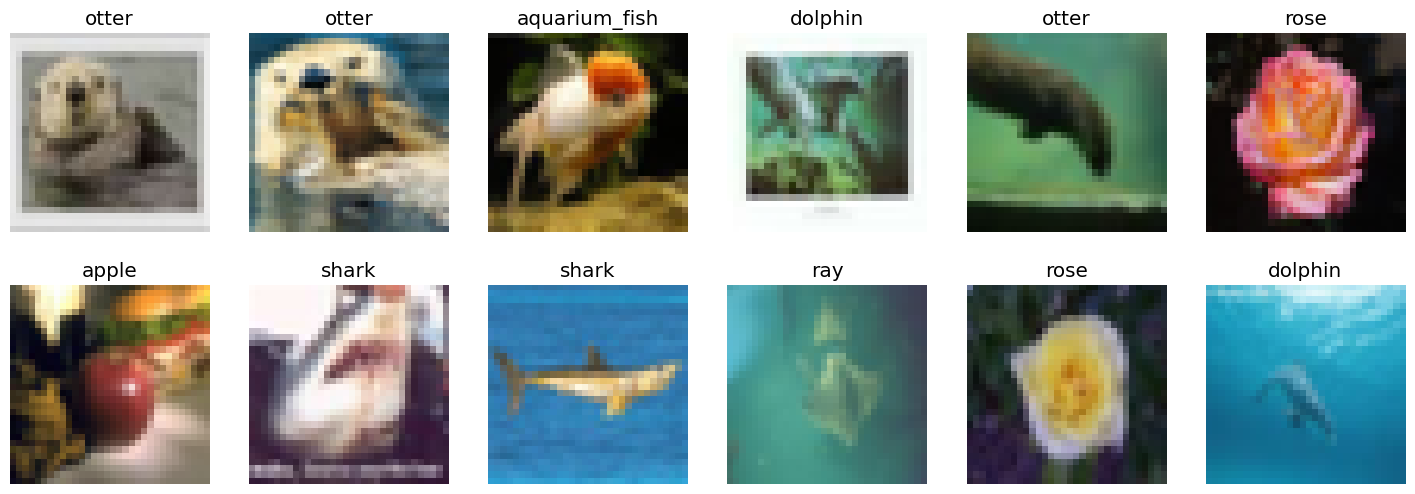

In [ ]:
print('Example of training data')
dl.train.show_batch(max_n=12, nrows=2)

Example of validation data


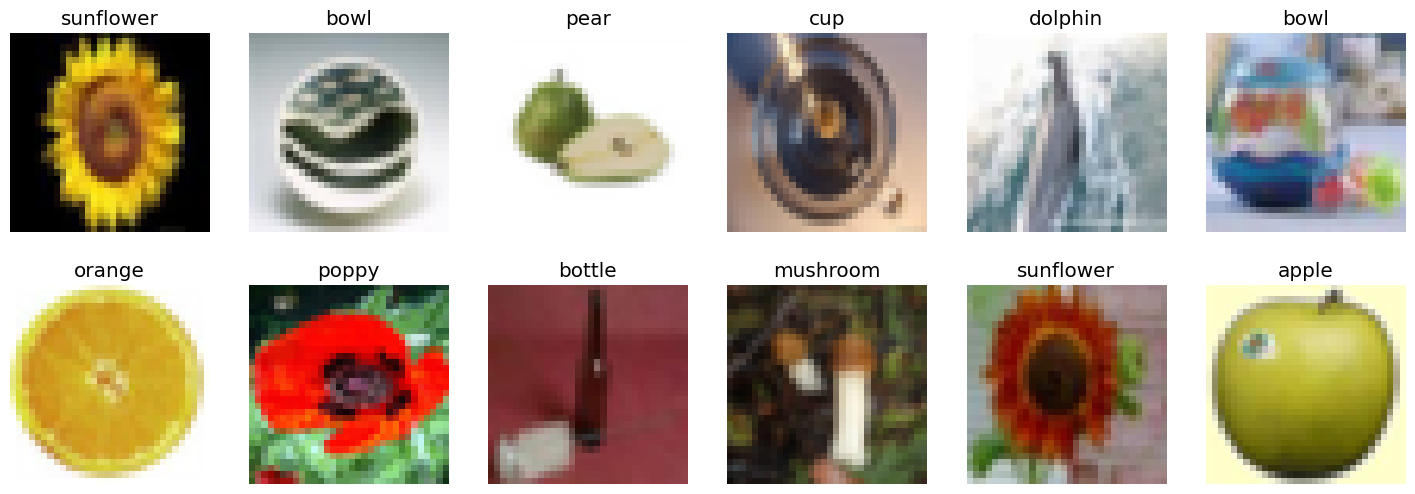

In [ ]:
print('Example of validation data')
dl.valid.show_batch(max_n=12, nrows=2)

Ahora procedemos con la creación y entrenamiento de la red BaseNet.

Los tipos de capas que se van a utilizar para construir la red son:
- nn.Conv2d(in_channels, out_channels, kernel_size)
  
  Capa convolucional que aplica una convolución 2D a la señal de entrada
  - in_channels: número de canales de la entrada
  - out_channels: número de canales de la salida. Los filtros tienen la misma profundidad que la entrada, por lo que este número coincide con el número de filtros.
  - kernel_size: tamaño del kernel
  
  Otros parámetros qe tienen valores definidos por defecto son:
  - stride=1: número de unidades que se mueve el kernel cada vez que este se mueve por la señal de entrada para aplicar la convolución. Por defecto 1.
  - padding=0: no hay padding por defecto. Por lo que el tamaño de la salida será menor que el de la entrada. Para conservar el tamaño de la imagen habría que espeficicar padding="same"

- nn.Linear(in_features, out_features)
  
  Capa fully-connected o densa. Todas las unidades de cada capa están conectadas a todas las unidades de la capa siguente.
  - in_features: dimensiones de la entrada
  - out_features: dimensiones de la salida

- nn.MaxPool2d(kernel_size)
  Capa de max pooling. Reduce la dimensonalidad de la entrada usando una ventana de del tamaño especificado en kernel_size. La salida tiene el valor máximo de cada ventana. No es una capa que tenga parámetros.
  - kernel_size: tamaño de la ventana

- nn.Flatten()
  Capa de Flatten. Aplana los datos multidimensionales con los que trabajan las capas convolucionales a vectores unidimensionales para que puedan utilizarse en una capa fully-connected. No es una capa que tenga parámetros.

- Funciones de activación:
  Ninguna de estas capas introducen parámetros al modelo:
  - nn.Sigmoid(): función de activación sigmoide. Devuelve valores entre 0 y 1
  - nn.Tanh(): función de activación hiperbólica tangente. Devuelve valores entre -1 y 1
  - nn.ReLu(): función de activación ReLu. La salida igual a cero cuando la entrada es negativa, y la salida es igual a la entrada cuando esta última sea positiva. Es de las funciones de activación más utilizadas.


Cabe destacar que las dimensiones de la entrada de la primera capa es 32x32x3, ya que estamos trabajando con imagenes de 32x32 y 3 canales. Por otro lado la última capa tiene 25 neuronas, ya que estamos ante un problema de clasificación con 25 clases diferentes.
La función de activación de la última capa es una Softmax. De esta forma todas las salidas estarán comprendidas entre 0 y 1 y sumarán 1 en total, lo que permite interpretar las salidas como las probabilidades de que la instancia dada pertenezca a cada clase de forma coherente. Sin embargo, no hay que añadir esta capa explícitamente en el modelo, como se explicará más adelante. De igual forma, al ser un problema de clasificación mlticlase, se usará como función de pérdida la entropía cruzada categórica durante el entrenamiento del modelo, que penaliza al modelo cuando estima una probabilidad baja para una clase objetivo.


Ahora, creamos el modelo con la arquitectura especificada anterioremente.

In [ ]:
BaseNet = sequential(
    # Entrada: 32x32x3 --> Salida: 24x24x5.     32-9+1 = 24
    nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(9,9)), # Primera capa convolucional con kernel 9x9
    nn.Sigmoid(), # Función de activación sigmoide

    # Entrada: 24x24x5 --> Salida: 12x12x5
    nn.MaxPool2d(kernel_size=(2,2)),  # Capa de MaxPooling 2x2

    # Entrada: 12x12x5 --> Salida: 6x6x10.    12-7+1 = 6
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=(7,7)), # Segunda capa convolucional con kernel 7x7
    nn.Tanh(),  # Función de activación tangente hiperbólica
    nn.Flatten(), # Capa de flattering
    nn.Linear(in_features=360, out_features=50), # Primera capa densa con 360 neuronas de entrada (6*6*10)
    nn.ReLU(),  # Función de activación ReLu
    nn.Linear(in_features=50, out_features=25)  # Segunda capa densa (capa de salida)
)
BaseNet

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

A continuación creamos el Learner, con nuestros datos, modelo, función de pérdida, optimizador y las métricas que se quieran monitorizar durante el entrenamiento del modelo.

Las métricas que se van a utilizar son el accuracy y el F1-score (weighted).

Recordemos que el accuracy mide la fracción de ejemplos clasificados correctamente. Es decir, el porcentaje de predicciones correctas sobre el total de predicciones realizadas.

El F1 score, en clasificación binaria, se calcula como la media armónica entre la precisión (proporción de instancias clasificadas como positivas que realmente lo son) y el recall (proporción de ejemplos positivos correctamente clasificados).

Para extender esto a clasificación multiclase, como es nuestro caso, existen varias aproximaciones. La que utilizamos es el F1-score weighted.

Para calcular el F1-score weighted, se calcula primero el F1 score para cada clase individualmente, y luego se promedia ponderando por el número de instancias de cada clase. Este enfoque da más peso a las clases con más ejemplos, lo que es útil especialmente cuando se trabaja con clases desbalanceadas. Sin embargo, incluso si las clases están balanceadas, este método sigue siendo útil ya que refleja el rendimiento del modelo en función de la distribución real de las clases en los datos.

Por otro lado, como ya hemos dicho, la función de pérdida que se va a utilizar es la entropía cruzada. Hay dos posibles opciones:
1. CrossEntropyLoss de PyTorch
2. CrossEntropyLossFlat de fastai

Se va a usar la segunda opción, que internamente llama a la primera, pero aplanando los tensores de predicciones y etiquetas. De esta forma, al hacer una predicción se obtendrá un único valor en lugar de un vector de 25.

Además, ambas opciones esperan recibir logits sin normalizar e internamente, aplica softmax para convertir los logits en probabilidades y luego calcula la pérdida. Por eso, si introdujéramos explícitamente una capa Softmax a nuestro modelo, estaríamos aplicando softmax dos veces, lo que produciría resultados inconsistentes.

También hemos especificado en el learner que queremos usar early stopping con una paciencia de 5, tal como se indica en el enunciado.

El early stopping es el método que se utiliza para evitar el sobreajuste. Consiste en monitorear la función de pérdida en un conjunto de validación durante el proceso de entrenamiento y detener el entrenamiento cuando el valor de función de pérdida en el conjunto de validación alcance el mínimo y empiece a aumentar (indicio de que se está sobreajustando el modelo). La paciencia define cuántas iteraciones adicionales se permitirán después de que el valor de la función de pérdida en la validación no mejore antes de detener el entrenamiento.

In [ ]:
learn = Learner(dl, # dataloader con los datos de entrenamiento
                BaseNet,  # modelo creado previamente
                loss_func=CrossEntropyLossFlat(), # indicamos que usamos la entropía cruzada como función de pérdida
                opt_func=Adam, # indicamos que queremos usar el optimizador Adam, aunque no sería necesario ya que este es el optimizador por defecto
                metrics=[accuracy, F1Score(average='weighted')],  # usamos como métricas accuracy y f1-score
                cbs=[EarlyStoppingCallback(patience=5)])  # early stopping con paciencia 5
learn.summary()

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     64 x 360            
Flatten                                                        
____________________________________________________________________________
                     64 x 50     



---



---



---



Comprobamos que el número de parámetros es el esperado.

**Cálculo del número de parámetros:**
- Las capas de activación y de pooling no tienen parámetros
- Primera capa convolucional: (9x9x3 + 1) x 5 = 1220
  - 9x9x3 porque el kernel es 9x9 y la señal de entrada tiene 3 canales
  - +1 por el bias
  - el resultado se multiplica por 5 porque se aplican 5 filtros
  - Contribución de la capa al número de parámetros: 5.30%

- Segunda capa convolucional: (7x7x5 + 1) x 10 = 2460
  - 7x7x5 porque el kernel es 7x7 y la entrada tiene 5 canales
  - +1 por el bias
  - el resultado se multiplica por 10 porque se aplican 10 filtros
  - Contribución de la capa al número de parámetros: 10.69%


- Primera capa densa: (360x50) + 50 = 18050: número de entradas x número de neuronas de la capa + 1 bias por neurona
  - Contribución de la capa al número de pesos: 78.46%

- Segunda capa densa: (50x25) + 25 = 1275: número de entradas x número de neuronas de la capa + 1 bias por neurona
  - Contribución de la capa al número de parámetros: 5.54%

  Número total de parámetros = 1220 + 2460 + 18050 + 1275 = 23005

  Vemos que la mayor parte de los parámetros se concentran en las capas densas (aproximádamente el 84%) porque cada neurona de una capa densa está conectada a todas las neuronas de la capa anterior, lo que genera una gran cantidad de pesos, en comparación con las capas convolucionales.

Para entrenar el modelo se va a usar la política de un ciclo de Leslie N. Smith, que consiste en lo siguiente:
Se divide el entrenamiento en dos etapas. Durante la primera se va aumentando el learning rate y se disminuyendo el momentum y durante la segunda se va disminuyendo el learning rate y aumentando el momentum. Cuando se entrena utilizando momentum en una red neuronal, al actualizar los gradientes, se tienen también en cuenta las gradientes previos y no solamente el último, lo que ayuda a acelerar el entrenamiento y saltar mínimos locales. La política de un ciclo  ha mostrado ser muy efectiva para acelerar la convergencia y mejorar el rendimiento en muchos modelos de redes neuronales.

Para encontrar el learning rate a usar como learning rate máximo, vamos a usar el learning rate finder, propuesto también por Leslie N. Smith.
Consiste en entrenar el modelo con cada learning rate durante una época o unas pocas iteraciones y mostrar un gráfica con la función de pérdida para cada learning rate. Posiblemente nos interesará quedarnos con el learning rate que se encuentre en el punto donde la pendiente de la gráfica es más pronunciada y por tanto nos permitirá avanzar rápido en el entrenamiento. El learning rate finder puede devolver varios valores según diferentes criterios. En lugar de usar el valor devuelto directamente, usaremos la gráfica para hacernos una idea de qué learning rates podrían funcionar bien, elegir dos o tres y probar con cuál de ellos se obtiene un mejor rendimento, es de decir, con cual se consigue minimizar el valor de la función de pérdida en validación

0.004365158267319202


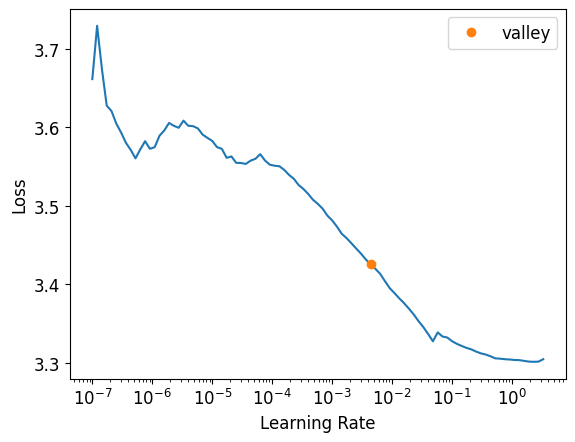

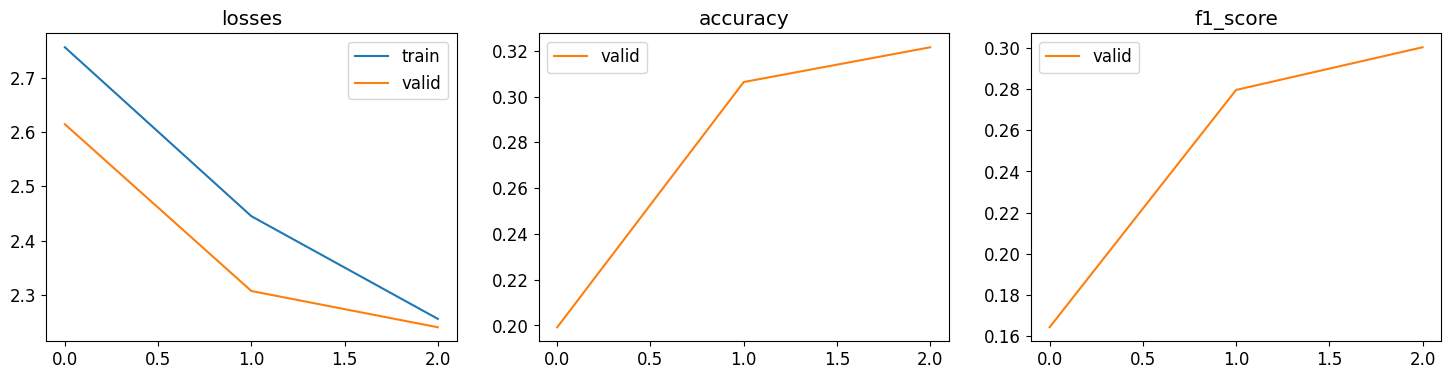

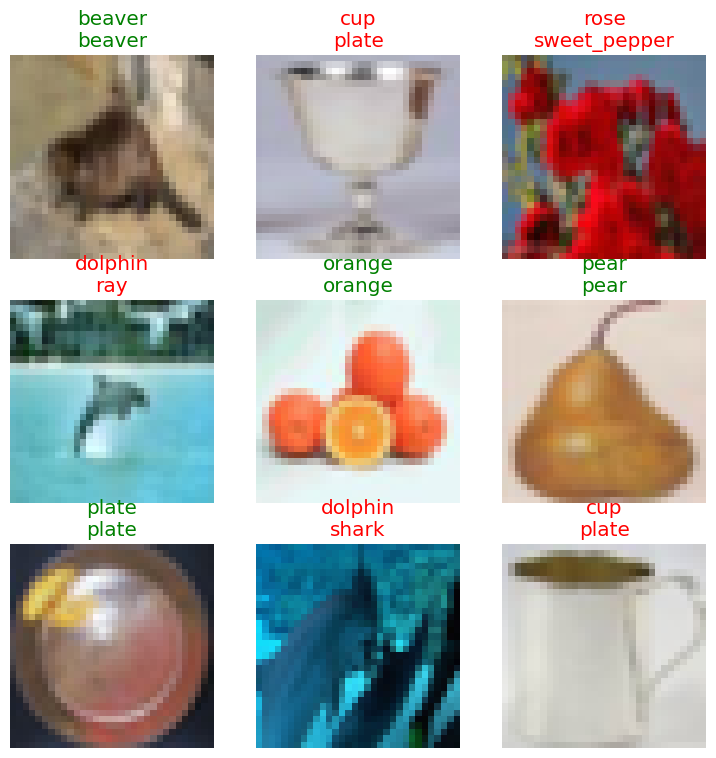

In [ ]:
lr = learn.lr_find() # Learning rate finder
print(lr[0])  # valor de learning rate encontrado
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0]) # entrenar unas pocas épocas (3)
learn.recorder.plot_metrics() # mostrar métricas en el entrenamiento
learn.show_results()



El valor de learning rate encontrado por lr_fin es 0.00437. Este valor parece adecuado ya que, como hemos comentado antes, la pendiente de la función de pérdida en ese punto es pronunciada. Y además, al entrenar 3 épocas con este learning rate vemos que la función de pérdida disminuye a un buen ritmo y la accuracy se incrementa considerablemente.
 Sin embargo, el tramo de pendiente es más largo así que se van a considerar dos valores más de learning rate: uno más pequeño que se encuentra un poco más arriba en la pendiente (0.0004) y otro más grande que se encuentra más abajo (0.01)

En cuanto al tamaño del batch, usar batches pequeños suele asociarse con una mejora de la capacidad de generalización del modelo, ya que es más probable que se encuentre un "flat minimun". Mientras que trabajando con batches más grandes es más probable quedarse en un "sharp minimun", por lo que el modelo podría generalizar peor. Por otro lado, se recomienda usar learning rates más grandes cuando se trabaja con la política de un ciclo, como es nuestro caso. Así que se van a considerar dos posibles valores para el tamaño de batch: un valor más grande (64) y otro más pequeño (32).

Ahora vamos a entrenar el modelo con los diferentes learning rates y batch size y nos quedarmos con los hiperparámetros con los que se consigan un menor valor de la función de pérdida en validación.

In [ ]:
learning_rates = [0.0004, lr[0], 0.01] # posibles valores del learning rate
batch_sizes = [32, 64] # posibles valores para el tamaño de batch
epochs = 25 # número de épocas

Learning Rate: 0.0004, Batch Size: 32


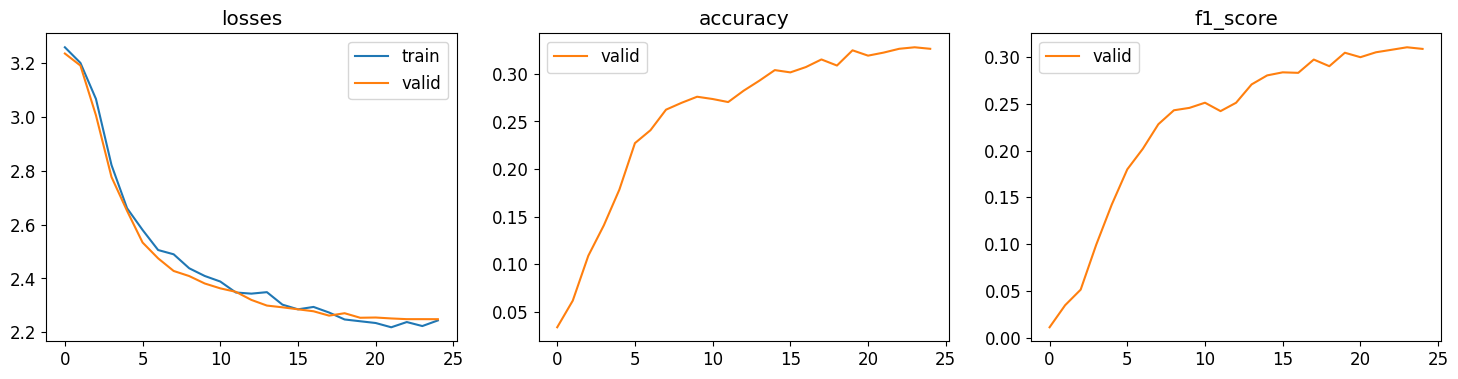

Valor mínimo de la función de pérdida en validación: 2.249075174331665
Learning Rate: 0.0004, Batch Size: 64


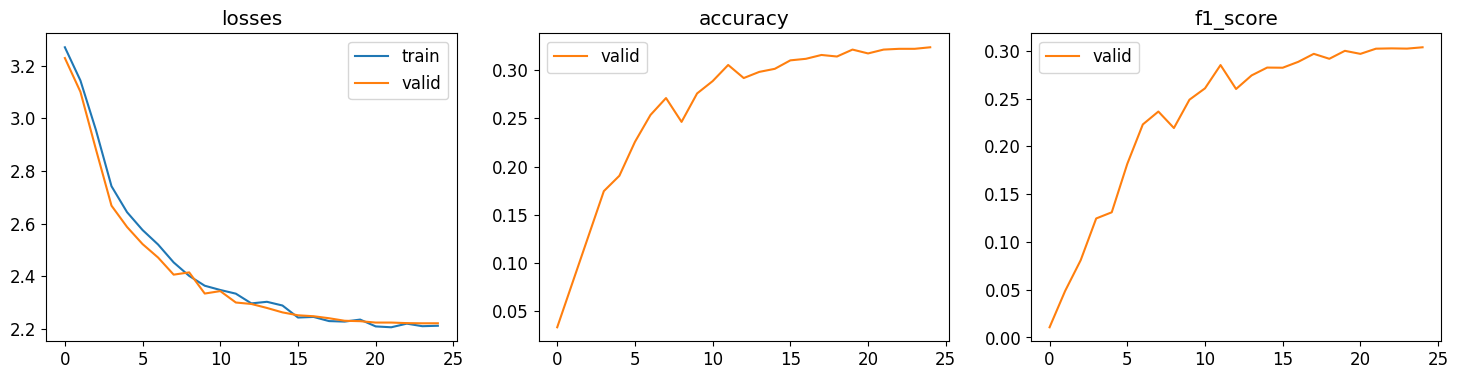

Valor mínimo de la función de pérdida en validación: 2.221879720687866
Learning Rate: 0.004365158267319202, Batch Size: 32


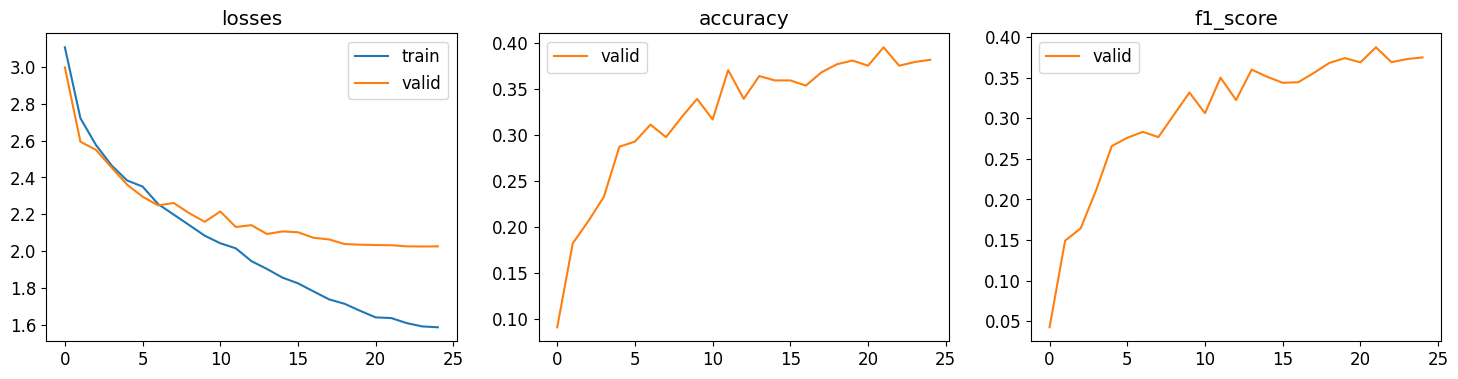

Valor mínimo de la función de pérdida en validación: 2.0253121852874756
Learning Rate: 0.004365158267319202, Batch Size: 64


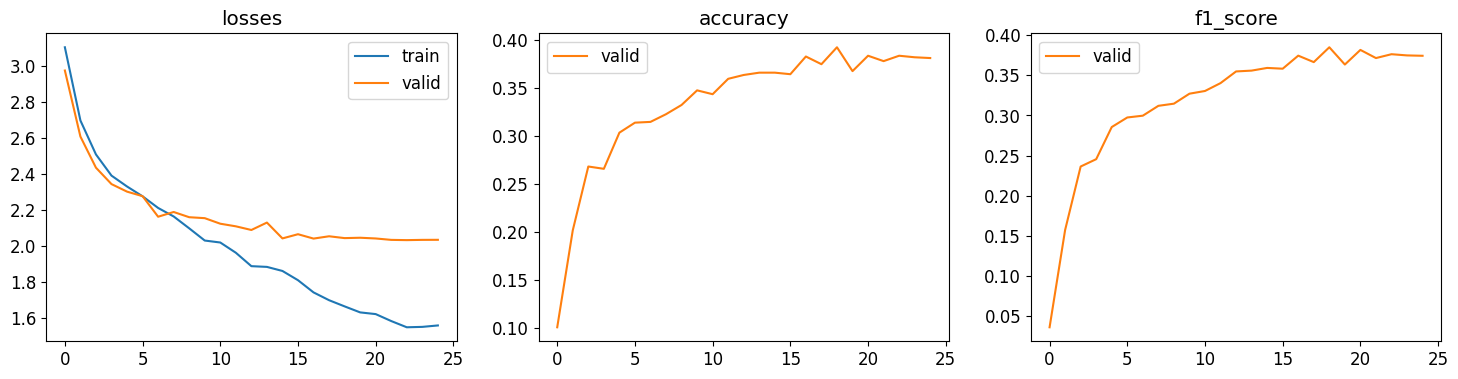

Valor mínimo de la función de pérdida en validación: 2.031745195388794
Learning Rate: 0.01, Batch Size: 32


No improvement since epoch 18: early stopping


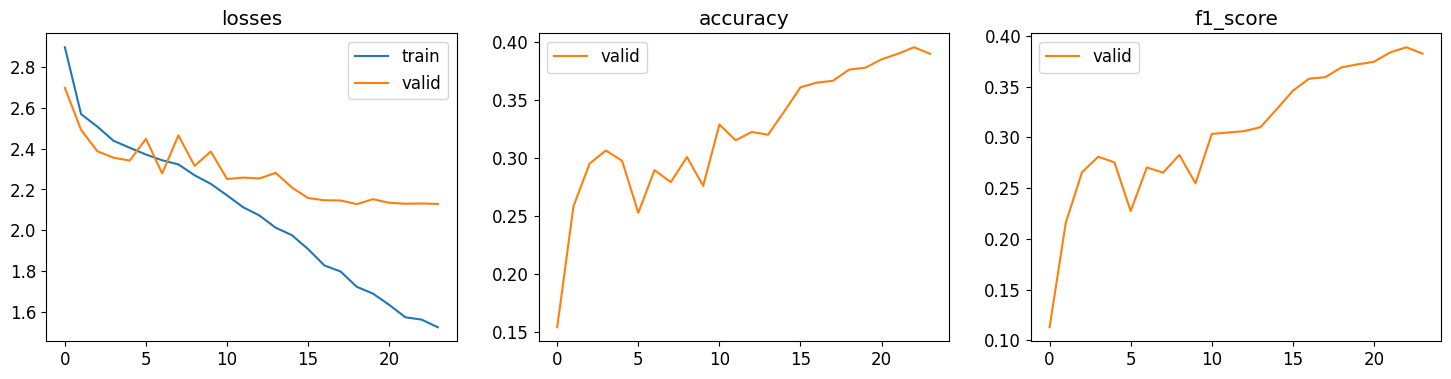

Valor mínimo de la función de pérdida en validación: 2.1278457641601562
Learning Rate: 0.01, Batch Size: 64


No improvement since epoch 17: early stopping


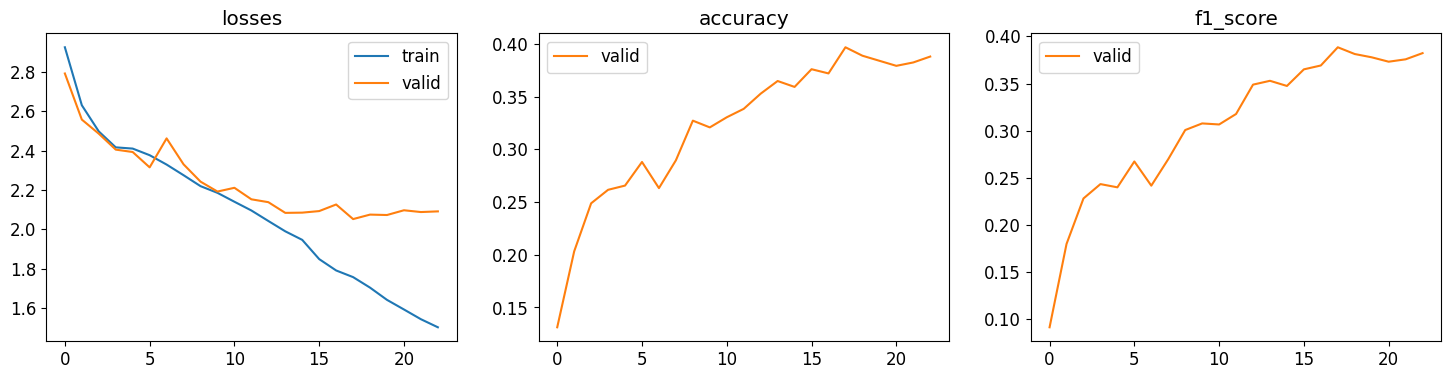

Valor mínimo de la función de pérdida en validación: 2.0525505542755127


In [ ]:
resultados = [] # lista para almacenar los resultados obtenidos con cada configuración de hiperparámetros
for lr in learning_rates:
    for bs in batch_sizes:
        print("Learning Rate: {}, Batch Size: {}".format(lr, bs))
        # Ajustar el tamaño del batch
        learn.dls.train.batch_size = bs
        learn.dls.valid.batch_size = bs

        # Reiniciar el modelo y el optimizador
        # Si se llama varias veces a fit_one_cycle se empieza a entrenar con los pesos resultantes de la llamada anterior. Por eso es
        # necesario reiniciar el modelo. También se reinicia el optimizador porque puede haberse quedado guardada información acerca
        # de los momentum u otra información residual
        apply_init(learn.model)
        learn.opt = learn.create_opt()

        # Entrenar el modelo con la política de un ciclo
        learn.fit_one_cycle(epochs, lr_max=lr)

        # Mostramos la evaluación de la función de pérdida y las métricas durante el entrenamiento
        learn.recorder.plot_metrics()

        # Recuperamos el valor mínimo de la función de pérdida (en validación) obtenido durante el entrenamiento
        min_loss = min(np.stack(learn.recorder.values)[:,1])
        print("Valor mínimo de la función de pérdida en validación: {}".format(min_loss))

        # Guardamos los resultados obtenidos
        resultados.append({"learning_rate": lr,
                        "batch_size": bs,
                        "min_loss": min_loss})


Nos quedamos con los mejores hiperparámetros: en este caso, el learning rate encontrado por el lr_finder y un tamaño de batch de 32.

In [ ]:
best_params = min(resultados, key=lambda x: x["min_loss"])

lr_best = best_params['learning_rate']
bs_best = best_params['batch_size']
print("Mejor learning rate encontrado: {}".format(lr_best))
print("Mejor batch size encontrado: {}".format(bs_best))

Mejor learning rate encontrado: 0.004365158267319202
Mejor batch size encontrado: 32


Entrenamos el modelo final con el mejor learning rate y el mejor batch size encontrado.

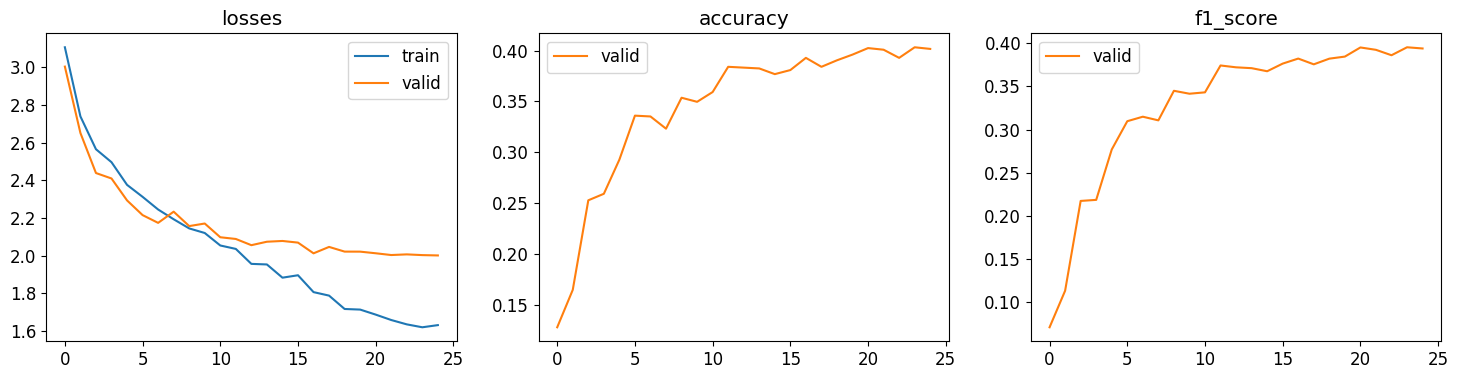

In [ ]:
# Actualizar batch size
learn.dls.train.batch_size = bs_best
learn.dls.valid.batch_size = bs_best

# Reiniciar el modelo y el optimizador
apply_init(learn.model)
learn.opt = learn.create_opt()

# Entrenar el modelo con la política de un ciclo y el learning rate encontrado
learn.fit_one_cycle(epochs, lr_max=lr_best)

# Mostrar la evaluación de la función de pérdida y las métricas durante el entrenamiento
learn.recorder.plot_metrics()

In [ ]:
# Data loaders con datos de validación y entrenamiento
dl_train = dl.train
dl_valid = dl.valid

**Resultados en validación**

Número de ejemplos de validación: 1250
Accuracy:  40.16 %


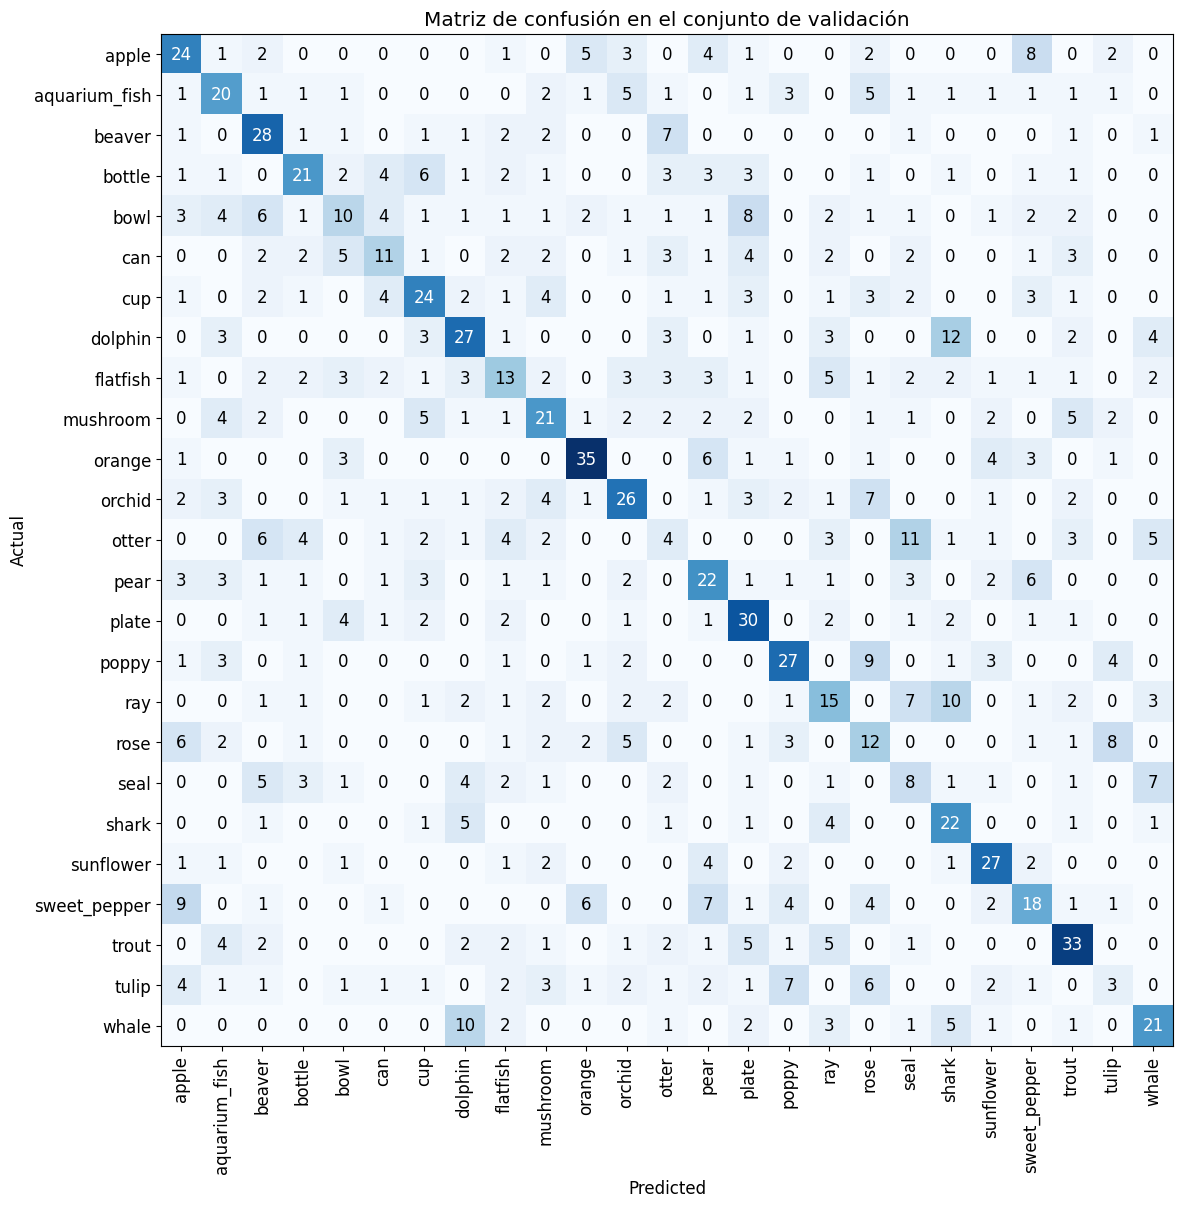

In [ ]:
# Realizamos las predicciones sobre el conjunto de validación y calculamos el accuracy y la matriz de confusión
preds_valid, targs_valid, _ = learn.get_preds(dl=dl_valid, with_decoded=True)
acc_valid = accuracy(preds_valid, targs_valid)

interp_valid = ClassificationInterpretation.from_learner(learn, 1, dl_valid)
cm_valid = interp_valid.confusion_matrix()
interp_valid.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en el conjunto de validación')

print('Número de ejemplos de validación:', np.sum(cm_valid))
print('Accuracy: ', round(float(acc_valid)*100, 4), '%')

Vemos que el resultado obtenido no es demasiado bueno. En el siguiente ejercicio se estudiarán cuales son los puntos débiles del modelo y como mejorarlo. Se obtiene una accuracy del 40.16% en validación, por lo que la mayor parte de las imágenes las clasifica erróneamente.

Podemos ver que hay clases en las que el desempeño del modelo es mejor que otras. Por ejemplo, la naranja la consigue clasificar bien 35 de 56 veces que aparece en el conjunto de validación (62.5%).

Por otro lado, hay clases en las que la accuracy conseguida extremadamente baja. El caso más extremo es el tulipán, que solo consigue clasificar bien 3 de 40 veces (7.5%). Aunque la mayor parte de las veces lo confunde con otras flores como la amapola y la rosa, así que dentro de lo que cabe tiene un sentido.

**Resultados en entrenamiento**

Número de ejemplos de validación: 11250
Accuracy:  49.2356 %


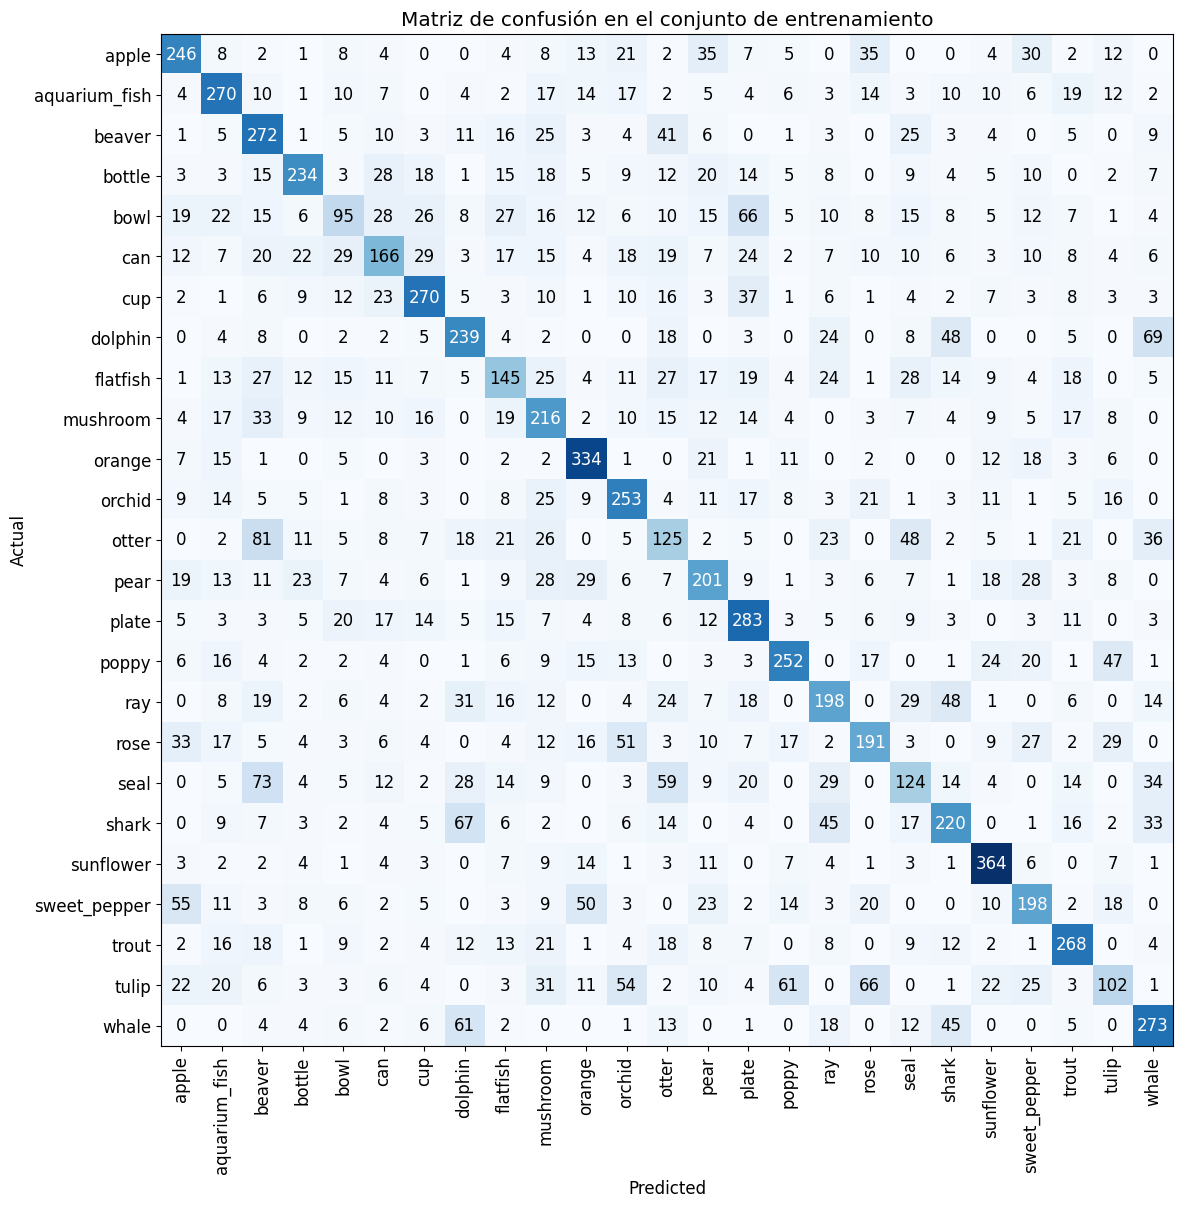

In [ ]:
# Realizamos las predicciones sobre el conjunto de entrenamiento y calculamos el accuracy y la matriz de confusión
preds_train, targs_train, _ = learn.get_preds(dl=dl_train, with_decoded=True)
acc_train = accuracy(preds_train, targs_train)

interp_train = ClassificationInterpretation.from_learner(learn, 1, dl_train)
cm_train = interp_train.confusion_matrix()
interp_train.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en el conjunto de entrenamiento')

print('Número de ejemplos de validación:', np.sum(cm_train))
print('Accuracy: ', round(float(acc_train)*100, 4), '%')

En entrenamiento, como cambía esperar, se obtienen mejores resultados, ya que se están haciendo las predicciones sobre ejemplos que ya ha visto el modelo durante el entrenamiento. Aún así, el desempeño del modelo sigue siendo bastante malo, no llegando no al 50% de accuracy.

Al igual que antes, podemos ver en la matriz de confusión que las clases con las que más se equivoca clases parecidas. Por ejemplo, confunde los cuencos con platos, algunas flores entre sí, las ballenas, tiburones y delfines, y los castores y las nutrias.

**Resultados en test**

Número de ejemplos de test: 2500
Accuracy:  39.32 %


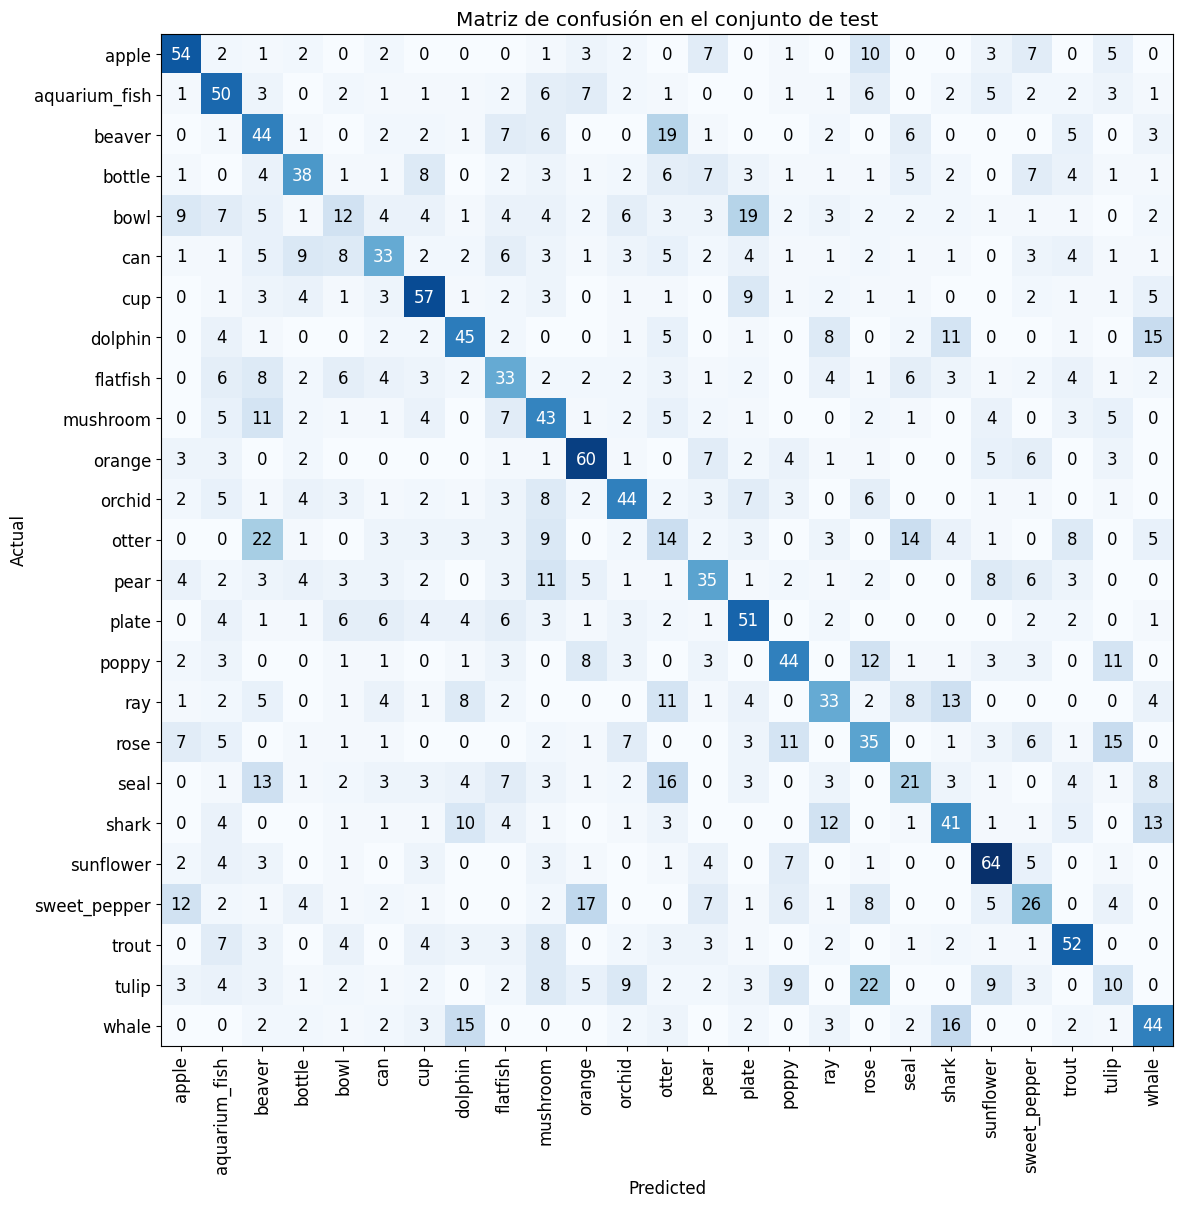

In [ ]:
# Creamos data loader para el conjunto de test
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]
dl_test = learn.dls.test_dl(test_files,with_labels=True)

# Realizamos las predicciones sobre el conjunto de test y calculamos el accuracy y la matriz de confusión
preds_test, targs_test, _ = learn.get_preds(dl=dl_test, with_decoded=True)
acc_test = accuracy(preds_test, targs_test)

interp_test = ClassificationInterpretation.from_learner(learn, 1, dl_test)
cm_test = interp_test.confusion_matrix()
interp_test.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en el conjunto de test')

print('Número de ejemplos de test:', np.sum(cm_test))
print('Accuracy: ', round(float(acc_test)*100, 4), '%')

Vemos que se obtiene un 39.32% de accuracy. Los resultados son bastante parecidos a los de validación, ya que los datos de test tampoco han sido vistos por el modelo durante el entrenamiento.

# <font color='blue'> **Ejercicio 2:** **Mejoras sobre el modelo BaseNet (4 puntos)**
<font color='blue'>Ahora el objetivo es crear una versión mejorada del modelo _Base Net_ (implementado en el anterior apartado). Para ello, se puede experimentar con distintas funciones de activación, funciones de pérdida, una mayor o menor profundidad de la red, un mayor o menor número de filtros por bloque convolucional, y/o diferentes técnicas de regularización u optimización, entre otras. De hecho, los alumnos deben sentirse libres para experimentar e incorporar todas las modificaciones que consideren pertinentes, incluyendo elementos no vistos ni en teoría ni en prácticas (por ejemplo, componentes que hayan podido descubrir a través de la revisión de artículos científicos). **Se valorará la originalidad y complejidad de la propuesta realizada.**

<font color='blue'>Es necesario destacar que **es imprescindible justificar de la mejor forma posible las decisiones tomadas** (ya sea mediante evidencia empírica o mediante literatura científica), **así como el rendimiento obtenido** (esto es, intentar explicar qué es lo que hace que mejore tanto el rendimiento). También es importante remarcar que **las mejoras introducidas, dentro de lo posible, deben realizarse de forma incremental**, es decir, no basta con crear directamente (de forma mágica) un único modelo y evaluarlo:  **es necesario justificar y describir qué pasos y resultados intermedios nos han llevado a diseñar ese modelo concreto**. Se debe describir cada una de las mejoras incorporadas, así como analizar los resultados obtenidos (del mismo modo que se hizo en el Ejercicio 1, y empleando los mismos criterios de partida; por ejemplo, usando un $10\%$ de los ejemplos de entrenamiento para validación). También es necesario, al igual que en el Ejercicio 1, desglosar el número de parámetros del modelo final, y se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido correctamente y que el número de parámetros se corresponde con lo esperado.  

<font color='blue'>Como referencia para los estudiantes, se espera que la _accuracy_ en validación alcance, como mínimo, el $65\%$.


Primero, vamos a normalizar los datos de entrada. Para ello, primero vamos a calcular la media y desviación estándar de los píxeles de cada canal. Luego, añadiremos Normalize.from_stats(mean, std) con la media y desviación estándar calculadas al conjunto de transformaciones del batch (batch_tfms) del DataBlock. Esto lo que hace es lo siguiente:

1. A cada canal (R, G, B) de la imagen se le resta el valor promedio correspondiente. Esto centra los datos alrededor de cero.

2. Después de centrar los datos, se dividen por la desviación estándar del canal correspondiente. Esto escala los datos para que tengan una desviación estándar de 1.

Normalizar los datos de entrada en una red neuronal suele mejorar la velocidad y estabilidad del entrenamiento al garantizar que todas las características tengan una escala similar, evitando problemas como la saturación de gradientes o la red preste más atención a las características con valores mayores, ignorando las de menor escala. Esto resultaría en pesos mal balanceados, una peor capacidad de generalización y una convergencia más lenta.


In [ ]:
import torch
# CÁLCULO DE LA MEDIA Y DESVIACIÓN ESTÁNDAR

# Creamos un DataBlock con los ejemplos de entrenamiento
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Entradas son imágenes, salidas son categorías
    get_items=get_image_files,          # Obtener archivos de imagen
    get_y=parent_label,                 # Etiquetas según la carpeta
    splitter=RandomSplitter(valid_pct=0, seed=42),
)

# Creamos los DataLoaders a partir del DataBlock
dl = db.dataloaders(path/'train', shuffle=False)

# Verifica el total de imágenes
total_images = 0
for batch in dl.train:
    images, _ = batch
    total_images += images.shape[0]

print(f"Total imágenes procesadas: {total_images}")

# Inicializa listas para acumular todos los valores de píxel
all_pixels = []

# Iterar sobre el DataLoader para obtener todas las imágenes
for batch in dl.train:
    images, _ = batch  # Las imágenes están en formato (batch_size, 3, height, width)
    all_pixels.append(images)

# Concatenar todas las imágenes a lo largo de la dimensión de batch
all_pixels = torch.cat(all_pixels, dim=0)  # Dimensión resultante: (num_total_images, 3, height, width)

# Reordena las dimensiones para trabajar con píxeles: (num_pixels, canales)
all_pixels = all_pixels.permute(1, 0, 2, 3).reshape(3, -1)

# Calcula la media y desviación estándar por canal
mean = all_pixels.mean(dim=1)
std = all_pixels.std(dim=1)

print(f'Media: {mean}')
print(f'Desviación estándar: {std}')


Total imágenes procesadas: 12500
Media: TensorImage([0.5094, 0.4775, 0.4268], device='cuda:0')
Desviación estándar: TensorImage([0.2891, 0.2647, 0.2854], device='cuda:0')


Una vez calculada la media y desviación estándar, definimos el DataBlock, aplicando la normalización.

Se usará también data augmentation. Esto es una técnica para aumentar la variedad del conjunto de entrenamiento que realiza modificaciones como rotaciones, traslaciones o cambios de escala de las imágenes. Esto puede ayudar al modelo a generalizar mejor y mejorar su capacidad de reconecer patrones.
Para ello, se usa aug_transforms, que aplica un conjunto predeterminado de transformaciones a las imágenes. Esta función recibe varios parámetros para poder especificar las transformaciones a realizar, pero por ahora se van a usar los parámetros por defecto, que normalmente proporcionan un buen resultado.

Algunos de sus parámetros más relevantes y sus valores por defecto son:

- do_flip: Si permite invertir la imagen horizontalmente. Por defecto True.

- flip_vert: Si permite realizar flips verticales. Por defecto False.

- size: Tamaño final de las imágenes después de las transformaciones (ancho y alto). Si es None, no se redimensiona. Por defecto None.

- max_rotate: Rotación máxima permitida en grados. Valor positivo indica rango entre -max_rotate y max_rotate. Por defecto 10.

- max_zoom: Factor máximo de zoom aplicado a la imagen. Por defecto 1.1.

- max_lighting: Intensidad máxima de las transformaciones de brillo y contraste. Por defecto 0.2.



Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


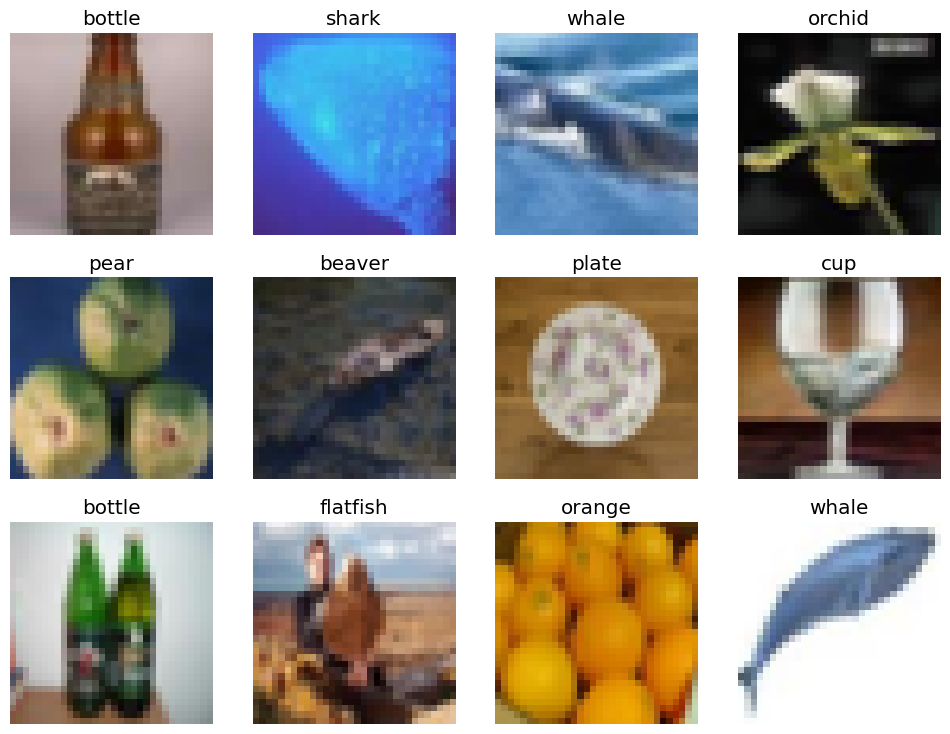

In [ ]:
# Definimos el DataBlock
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # las entradas son imágenes y las salidas categorías
    get_items=get_image_files,  # recuperar imágenes del path (imágenes del conjunto de entrenamiento)
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # separar un 10% del conjunto de entrenamiento para validación
    get_y=parent_label, # las etiquetas de las imágenes se obtienen del nombre del directorio en que se se encuentran
    batch_tfms= [aug_transforms,  # data augmentation
                 Normalize.from_stats(mean, std)] # normalización
)

# Creamos los DataLoaders a partir del DataBlock
dl = db.dataloaders(path/'train')
#db.summary(path)

dl.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dl.train_ds))
print('Numero de ejemplos de validacion:', len(dl.valid_ds))

---



---



---

## Primer modelo

Estos son los cambios introducidos al modelo, respecto con el modelo del primer ejercicio.

- **Aumento de la profundidad de la red y del número de filtros**
  
  El número de filtros de la red del primer apartado era bastante bajo y solo tenía 2 capas convolucionales y una capa densa oculta. Aumentando el número de filtros y de capas se aumenta la comlejidad de la red, permitiendo que la red aprenda representaciones más complejas y jerárquicas. Así que se ha aumentado el número de filtros de la primera capa a 32, y el de la segunda a 64. Además, se ha añadido una capa convolucional más con 128 filtros y otra capa densa adicional.

- **Uso de Dropout**

  El dropout es una de las técnicas de regularización más populares para redes neuronales profundas. Se basa en que en cada paso de entrenamiento, cada neurona tiene una probabilidad p de ser ignorada en esa época del entrenamiento. Al hiperparámetro p se denomina tasa de abandono y se suele fijar entre el 40% y el 50% en redes neuronales convolucionales según la literatura. Siguiendo estas recomendaciones, fijaremos esta tasa en 50%.
  
  El dropout aumenta la robustez de la red, ya que evita que la red dependa excesivamente de una neurona específica.  Es decir, el dropout ayuda a evitar que las redes neuronales memoricen los datos de entrenamiento y en su lugar aprendan patrones más útiles y generalizables. Esta técnica se suele utilizar en las capas fully-connected, excepto en la capa de salida, ya que no tendría mucho sentido. Recordemos que la capa de salida tiene una neurona por cada clase y, como estamos usando Softmax como función de activación ,sus salidas se pueden interpretar como la probabilidad de que la instancia actual pertenezca a cada clase. Si aplicamos dropout en esta capa, estaríamos provocando que, durante el entrenamiento, algunas clases no puedan ser predichas, lo que podría perjudicar a la capacidad del modelo para aprender la distribución correcta de probabilidades.

- **Uso de Batch Normalization**

  Como hemos comentado, normalizar las entradas puede acelerar el entrenamiento. La idea de batch normalization es normalizar también la entrada de cada capa oculta de la red.

  La técnica consiste en, justo antes de la función de activación de cada capa oculta (esto es lo más común, aunque también se puede hacer justo después), normalizar la entrada (restando la media del mini-batch y dividiendo por la varianza), luego escalar y desplazar el resultado utilizando dos nuevos vectores de parámetros por capa: uno para la escala y otro para el desplazamiento. Esto permite al modelo aprender la escala y la media óptimas de cada una de las entradas de la capa.

  Una de las ventajas del uso de Batch Normalization es que puede ayudar al reducir el problema de desvanecimiento de gradientes: durante la retropropagación, los gradientes se suelen ir haciendo cada vez más pequeños al avanzar a las capas inferiores, lo que provoca que los pesos de las neuronas de las capas inferiores apenas cambien o cambien más lentamente que los de las neuronas de las capas superiores. Además, acelera la convergencia, lo que permite entrenar el modelo más rápido. También reduce la sensibilidad al valor inicial de los parámetros y puede ayudar a evitar el sobreajuste.

- **Reducción del tamaño de los filtros**
  Se va a disminuir el tamaño de los kernels a 3x3. Usar kernels pequeños permiten captar características más finas y sutiles de las imágenes. Además, evita que el número de parámetros de la red aumente demasiado, lo que disminuye el riesgo de sobreajuste y permite mejorar la capacidad de generalización de la red.

- **Usar solamente ReLu como función de activación**

  En el modelo del primer apartado se usaban tres funciones de activación diferentes: sigmoide, tangente hiperbólica (Tanh) y ReLU.
  Probablemente la función sigmoide no sea la más apropiada. Aunque antes era ampliamente utilizada, su usó disminuyó porque favorece el desvanecimiento de gradientes. Ya que cuando las entradas son grandes (negativas o positivas), la función se satura en 0 o 1, y su derivada está muy cercana a 0. Este problema se actentúa al aumentar la profundidad de la red. La función tangente hipernbólica, aunque su rango está entre -1 y 1, en lugar que entra 0 y 1, también tiene este problema. En cambio la ReLU no tiene este problema. Recordemos que la función RelU es 0 para valores negativos y lineal para positivos. De esta forma, no satura para valores positivos y además, tiene la ventaja de que es muy rápida de calcular.



A continuación se detallan todas las capas del nuevo modelo.


  **MODELO 1**

  En todas las capas convolucionales se usa un padding de 1 para mantener las mismas dimensiones de entrada que de salida y así evitar que el tamaño de la entrada disminuya muy rápidamente.

  - **Capa convolucional 2D con 32 filtros**. Tamaño entrada: 32x32x3. Tamaño salida = 32x32x32. Tamaño del kernel 3x3. Padding=1

  - **Batch Normalization**

  - **ReLU**

  - **Capa de max pooling 2x2**. Tamaño de la entrada: 32x32x32. Tamaño de la salida: 16x16x32

  - **Capa convolucional 2D con 64 filtros**. Tamaño entrada: 16x16x32. Tamaño salida = 16x16x64. Tamaño del kernel 3x3. Padding=1

  - **Batch Normalization**

  - **ReLU**

  - **Capa de max pooling 2x2**. Tamaño de la entrada: 16x16x64. Tamaño de la salida: 8x8x64

  - **Capa convolucional 2D con 128 filtros**. Tamaño entrada: 8x8x64. Tamaño salida = 8x8x128. Tamaño del kernel 3x3. Padding=1

  - **Batch Normalization**

  - **ReLU**

  - **Capa de max pooling 2x2**. Tamaño de la entrada: 8x8x128. Tamaño de la salida: 4x4x128


  - **Capa densa**. Tamaño entrada: 4x4x128=2048. Tamaño salida: 512

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.5**

  - **Capa densa**. Tamaño entrada: 512. Tamaño salida: 128

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.5**

  - **Capa densa de salida**. Tamaño entrada: 128. Tamaño salida: 25

  - **Solftmax**


In [ ]:
import torch.nn as nn

BaseNetMejorado = nn.Sequential(
    # Primera capa convolucional
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Segunda capa convolucional
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Tercera capa convolucional
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Flatten de la salida de las capas convolucionales
    nn.Flatten(),

    # Primera capa densa con Dropout
    nn.Linear(in_features=2048, out_features=512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.5),

    # Segunda capa densa con Dropout
    nn.Linear(in_features=512, out_features=128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(p=0.5),

    # Capa de salida
    nn.Linear(in_features=128, out_features=25)  # 25 clases de salida
)


A continuación creamos el learner. Usamos la misma función de pérdida: CrossEntropyLossFlat, que es las más adecuada por los motivos que ya se explicaron en el ejercicio anterior. También utilizaremos las mismas métricas: accuracy y f1 score y el mismo optimizador: Adam.

Al utilizar dropout, posiblemente la convergencia sea un poco más lenta y la curva de apredizaje más errática, por lo que se va a aumentar la paciencia del early stopping de 5 a 10.

In [ ]:
learn = Learner(dl, # dataloader con los datos de entrenamiento
                BaseNetMejorado,  # modelo creado previamente
                loss_func=CrossEntropyLossFlat(), # indicamos que usamos la entropía cruzada como función de pérdida
                opt_func=Adam, # indicamos que queremos usar el optimizador Adam, aunque no sería necesario ya que este es el optimizador por defecto
                metrics=[accuracy, F1Score(average='weighted')],  # usamos como métricas accuracy y f1-score
                cbs=[EarlyStoppingCallback(patience=10)])  # early stopping con paciencia 10
learn.summary()

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 32 x 32   
Conv2d                                    896        True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 16 x 16   
Conv2d                                    18496      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 8 x 8     
MaxPool2d                                     

Podemos observar que el número de parámetros del modelo es significativamente mayor que el del modelo del ejercicio anterior: hemos pasado de 23005 parámetros a más de 1.2 millones. Con esto se espera que el nuevo modelo sea capaz de aprender patrones más complejos y que esto se traduzca en un mejor rendimiento.

Sin embargo, es importante destacar que un mayor número de parámetros no garantiza automáticamente un mejor desempeño. El rendimiento final depende de muchos factores, como el grado de regularización del modelo y cómo estén de optimizados sus parámetros.

Ahora usamos el learning rate finder para encontrar un learning rate adecuado.

0.0014454397605732083


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

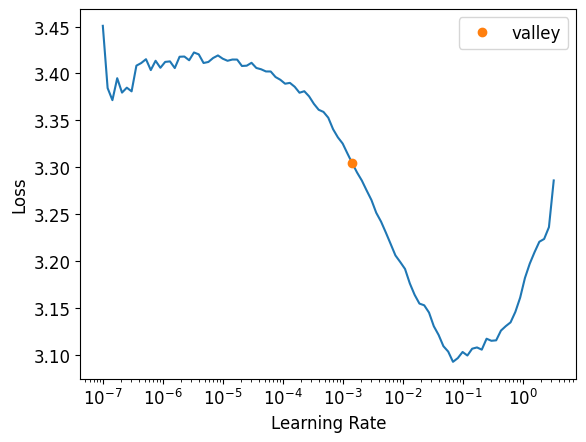

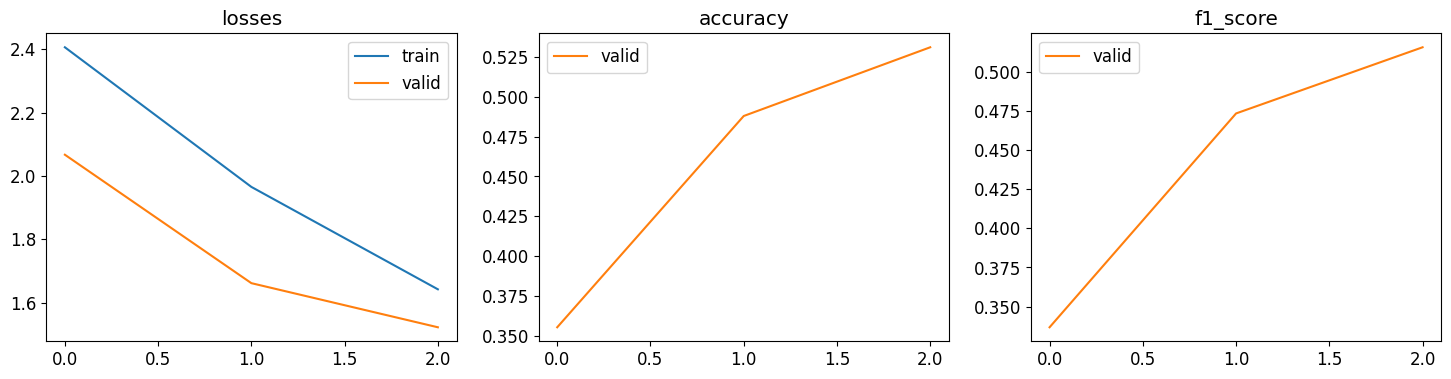

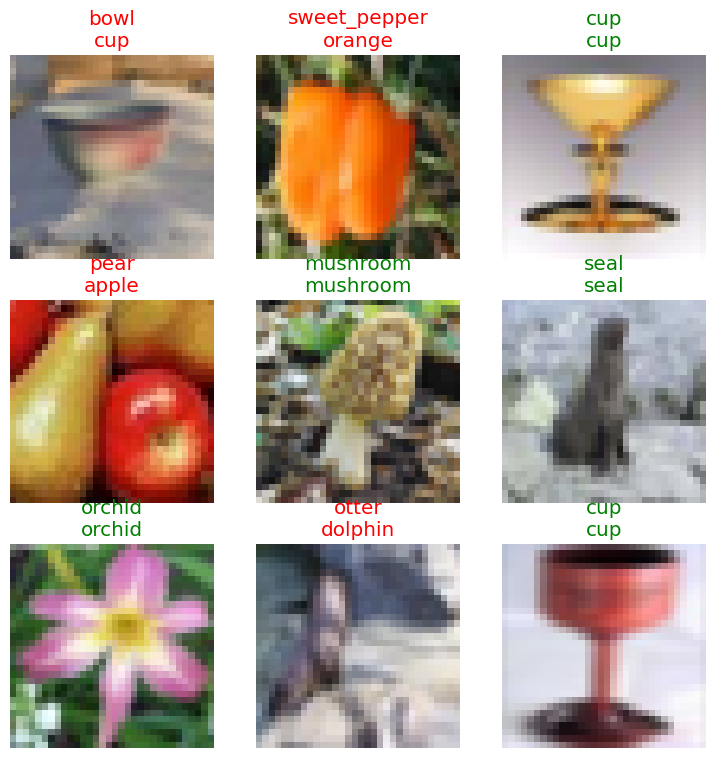

In [ ]:
#apply_init(learn.model)
#learn.opt = learn.create_opt()
lr = learn.lr_find() # Learning rate finder
print(lr[0])  # valor de learning rate encontrado
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0]) # entrenar unas pocas épocas (3)
learn.recorder.plot_metrics() # mostrar métricas en el entrenamiento
learn.show_results()

Observando la gráfica, podemos ver que un rango adecuado para el learning rate sería desde 0.0007 a 0.02 aproximadamente, lo que coincide con el tramo de mayor pendiente de la gráfica. Se va a probar con el valor encontrado por el learning rate finder, que se encuentra en dicho tramo, un valor un poco más pequeño (0.0007) y otro más grande (0.01). Al igual que en el ejercicio anterior, los dos valores del batch size que consideraremos con 32 y 64.

In [ ]:
learning_rates = [0.0007, lr[0], 0.01] # posibles valores del learning rate
batch_sizes = [32, 64] # posibles valores para el tamaño de batch
epochs = 50 # número de épocas

Entrenamos el modelo para todas las combinaciones de learning rates y tamaños de batch y vemos cual es la que minimiza el valor de la función de pérdida en validación.

Learning Rate: 0.0007, Batch Size: 32


No improvement since epoch 14: early stopping


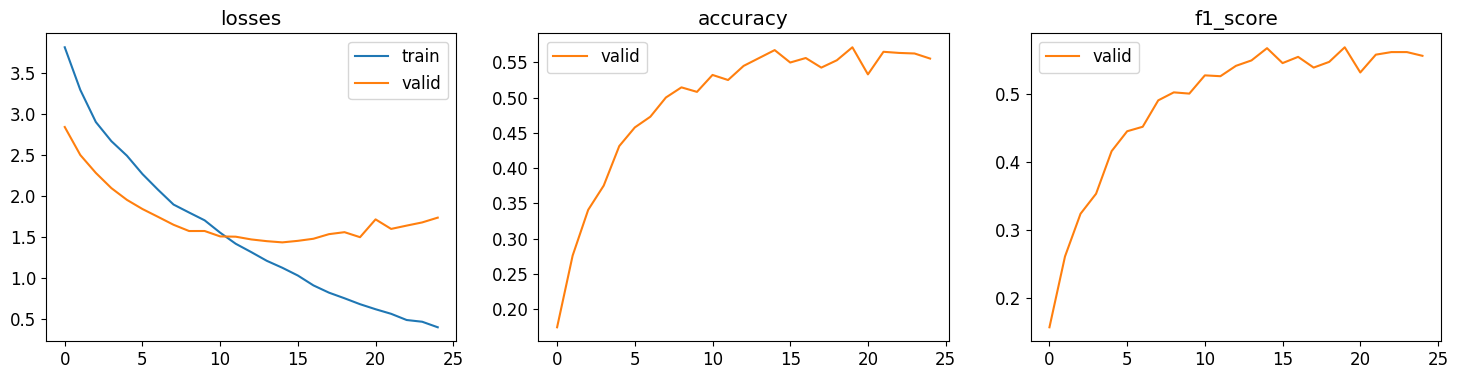

Valor mínimo de la función de pérdida en validación: 1.4358035326004028
Learning Rate: 0.0007, Batch Size: 64


No improvement since epoch 17: early stopping


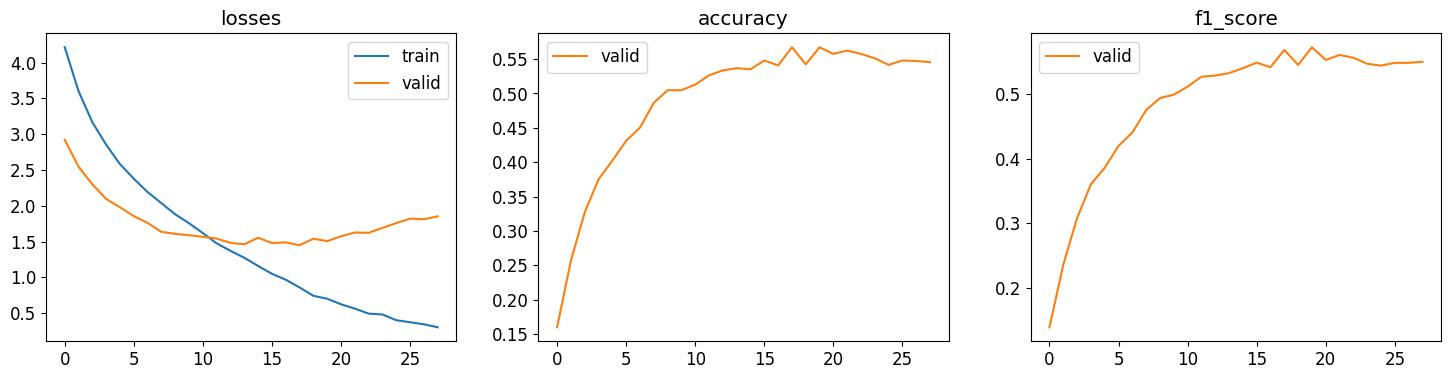

Valor mínimo de la función de pérdida en validación: 1.4500367641448975
Learning Rate: 0.0014454397605732083, Batch Size: 32


No improvement since epoch 12: early stopping


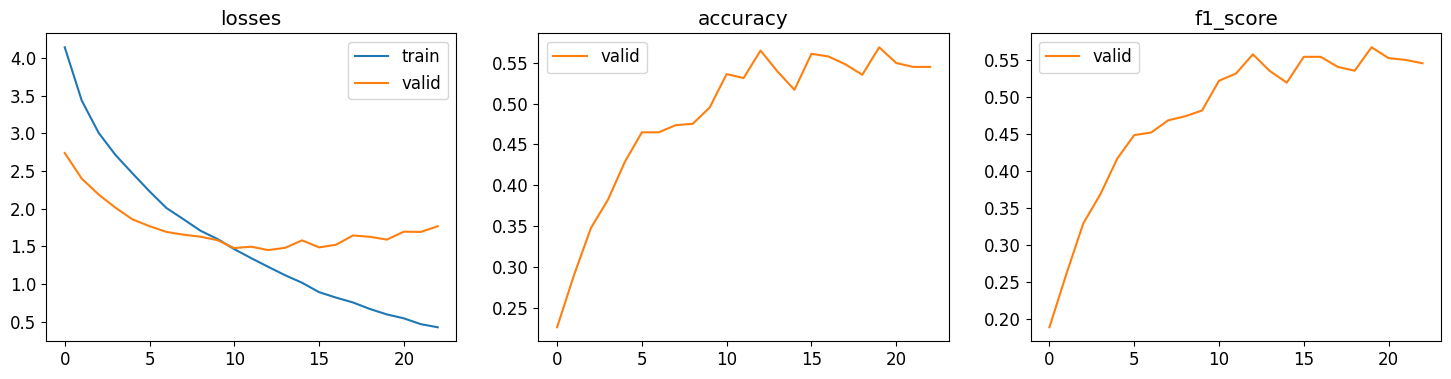

Valor mínimo de la función de pérdida en validación: 1.450150966644287
Learning Rate: 0.0014454397605732083, Batch Size: 64


No improvement since epoch 11: early stopping


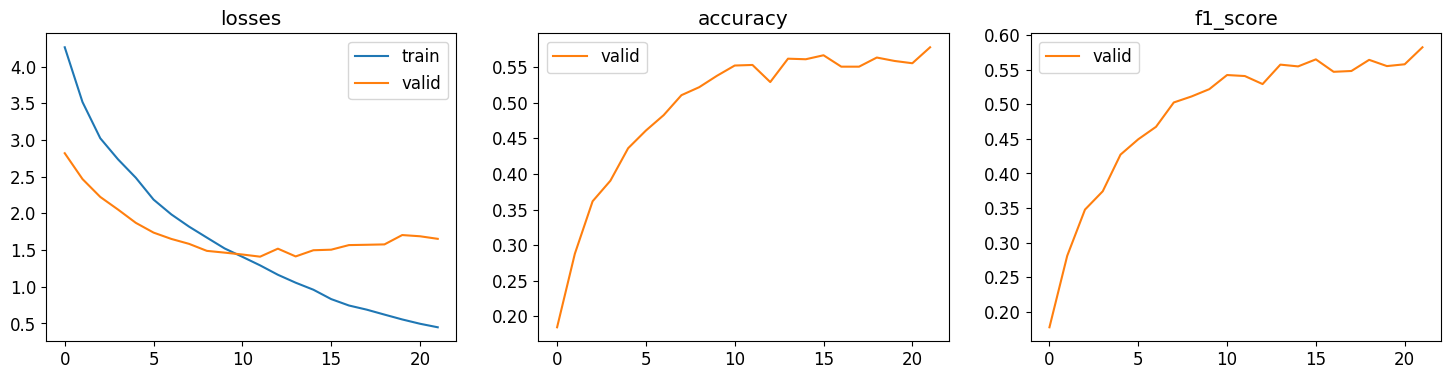

Valor mínimo de la función de pérdida en validación: 1.4101450443267822
Learning Rate: 0.01, Batch Size: 32


No improvement since epoch 12: early stopping


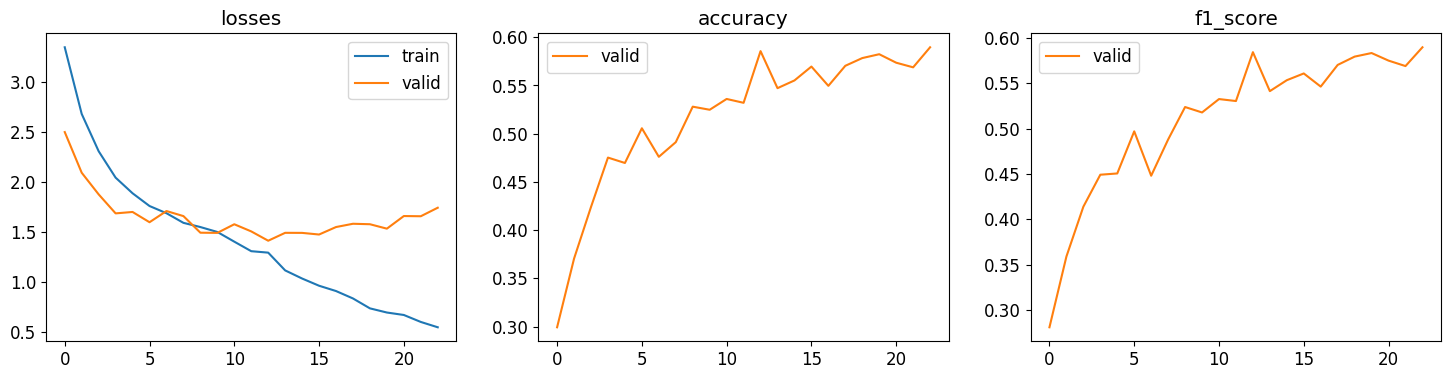

Valor mínimo de la función de pérdida en validación: 1.409233570098877
Learning Rate: 0.01, Batch Size: 64


No improvement since epoch 15: early stopping


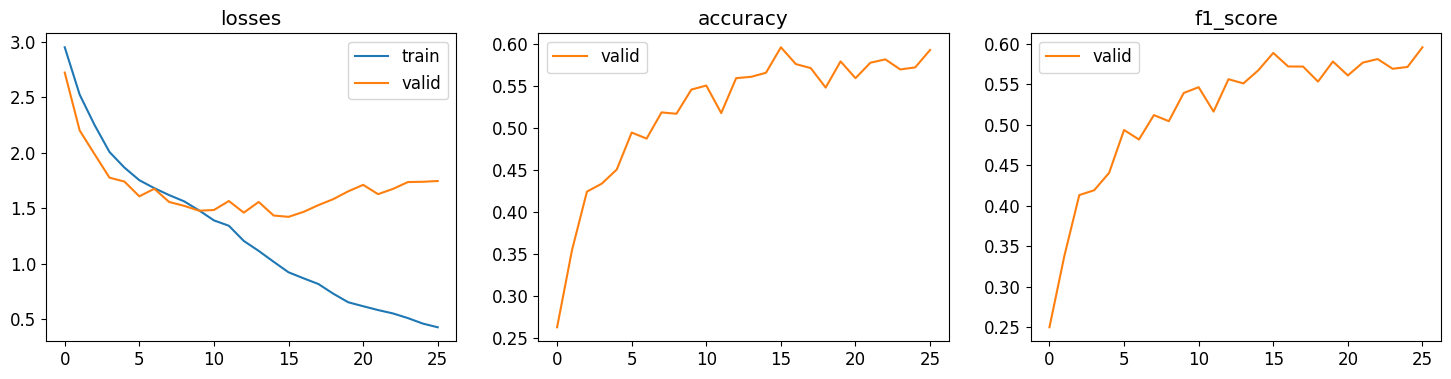

Valor mínimo de la función de pérdida en validación: 1.4234074354171753


In [ ]:
resultados = [] # lista para almacenar los resultados obtenidos con cada configuración de hiperparámetros
for lr in learning_rates:
    for bs in batch_sizes:
        print("Learning Rate: {}, Batch Size: {}".format(lr, bs))
        # Ajustar el tamaño del batch
        learn.dls.train.batch_size = bs
        learn.dls.valid.batch_size = bs

        # Reiniciar el modelo y el optimizador
        # Si se llama varias veces a fit_one_cycle se empieza a entrenar con los pesos resultantes de la llamada anterior. Por eso es
        # necesario reiniciar el modelo. También se reinicia el optimizador porque puede haberse quedado guardada información acerca
        # de los momentum u otra información residual
        apply_init(learn.model)
        learn.opt = learn.create_opt()

        # Entrenar el modelo con la política de un ciclo
        learn.fit_one_cycle(epochs, lr_max=lr)

        # Mostramos la evaluación de la función de pérdida y las métricas durante el entrenamiento
        learn.recorder.plot_metrics()

        # Recuperamos el valor mínimo de la función de pérdida (en validación) obtenido durante el entrenamiento
        min_loss = min(np.stack(learn.recorder.values)[:,1])
        print("Valor mínimo de la función de pérdida en validación: {}".format(min_loss))

        # Guardamos los resultados obtenidos
        resultados.append({"learning_rate": lr,
                        "batch_size": bs,
                        "min_loss": min_loss})


In [ ]:
best_params = min(resultados, key=lambda x: x["min_loss"])

lr_best = best_params['learning_rate']
bs_best = best_params['batch_size']
print("Mejor learning rate encontrado: {}".format(lr_best))
print("Mejor batch size encontrado: {}".format(bs_best))

Mejor learning rate encontrado: 0.01
Mejor batch size encontrado: 32


El valor mínimo de la función de pérdida con lr=0.01 y bs=32 es 1.409.

Observando las gráficas podemos darnos cuenta que la función de pérdida, tanto en validación como en entrenamiento, decerecen muy rápidamente al inicio. Sin embargo, después de unas pocas épocas, la función de pérdida en validación comienza a decrecer más lentamente y alcanza su mínimo en la época 12, momento a partir del cual comienza a crecer. Mientras, la función de pérdida en entrenamiento sigue decreciendo. La diferencia entre la función de pérdida en validación y entrenamiento se va acentuando significativamente conforme transcurren las épocas, indicio de que se está sobreajustando.

La accuracy y el f1 score siguen aumentando (aunque más lentamente), cuando la función de pérdida empienza a aumentar también. En las primeras etapas del sobreajuste, es posible que las métricas como la precisión y F1 score sigan mejorando, incluso cuando la pérdida de validación aumenta.


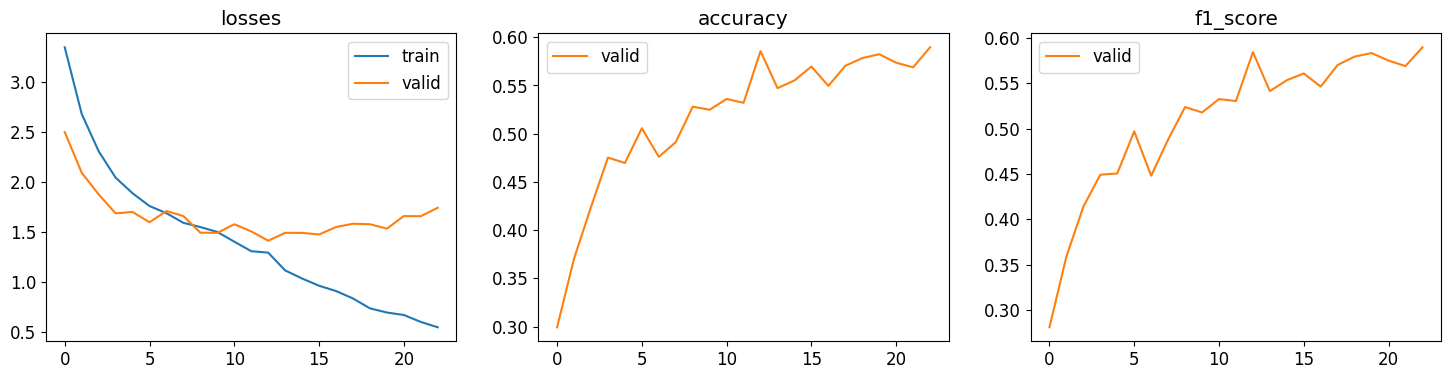

## Segundo modelo


Para tratar de evitar el problema de sobreajuste del modelo anterior vamos a utilizar un data augmentation intenso. Permitiendo flips verticales, además de los horizontales, rotaciones más pronunciadas (de hasta 30º), más zoom y mayores cambios en la iluminación y contraste de las imágenes. También, añadiremos dropout a las capas convolucionales, aunque en menor medida (30%), manteniendo el dropout de las capas densas igual.


Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


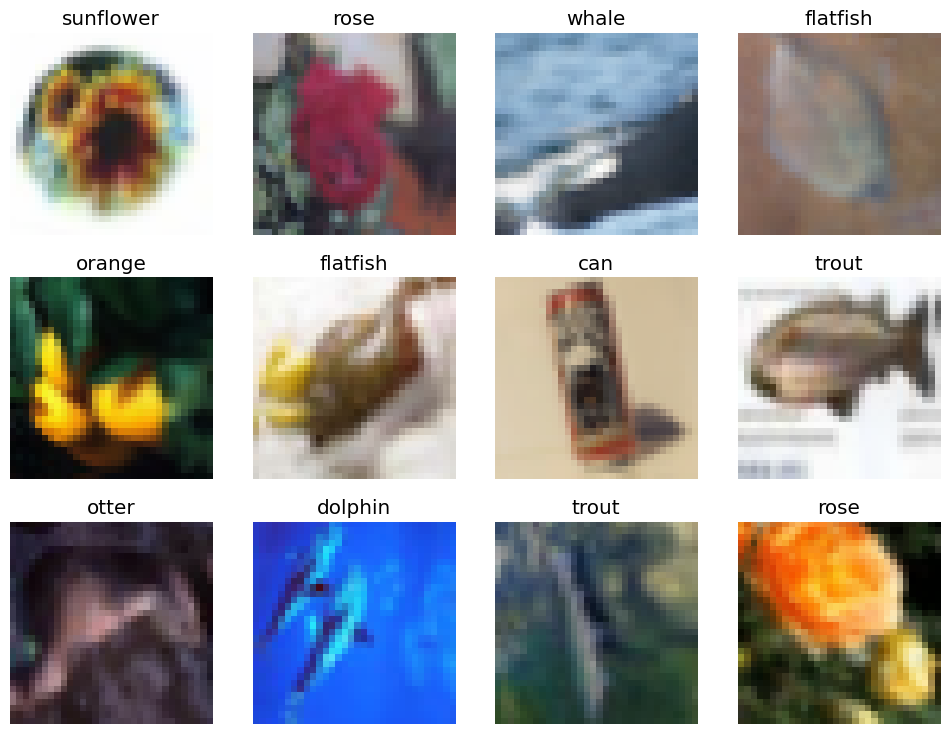

In [ ]:
# Definimos el DataBlock
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # las entradas son imágenes y las salidas categorías
    get_items=get_image_files,  # recuperar imágenes del path (imágenes del conjunto de entrenamiento)
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # separar un 10% del conjunto de entrenamiento para validación
    get_y=parent_label, # las etiquetas de las imágenes se obtienen del nombre del directorio en que se se encuentran
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=30, max_zoom=1.2, max_lighting=0.3) + [Normalize.from_stats(mean, std)] # data augmentation más agresivo y normalización
)
# Creamos los DataLoaders a partir del DataBlock
dl = db.dataloaders(path/'train')
#db.summary(path)

dl.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dl.train_ds))
print('Numero de ejemplos de validacion:', len(dl.valid_ds))

A continuación se detallan todas las capas del nuevo modelo.


  **MODELO 2**

  En todas las capas convolucionales se usa un padding de 1 para mantener las mismas dimensiones de entrada que de salida y así evitar que el tamaño de la entrada disminuya muy rápidamente.

  - **Capa convolucional 2D con 32 filtros**. Tamaño entrada: 32x32x3. Tamaño salida = 32x32x32. Tamaño del kernel 3x3. Padding=1

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.3**

  - **Capa de max pooling 2x2**. Tamaño de la entrada: 32x32x32. Tamaño de la salida: 16x16x32

  - **Capa convolucional 2D con 64 filtros**. Tamaño entrada: 16x16x32. Tamaño salida = 16x16x64. Tamaño del kernel 3x3. Padding=1

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.3**

  - **Capa de max pooling 2x2**. Tamaño de la entrada: 16x16x64. Tamaño de la salida: 8x8x64

  - **Capa convolucional 2D con 128 filtros**. Tamaño entrada: 8x8x64. Tamaño salida = 8x8x128. Tamaño del kernel 3x3. Padding=1

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.3**

  - **Capa de max pooling 2x2**. Tamaño de la entrada: 8x8x128. Tamaño de la salida: 4x4x128


  - **Capa densa**. Tamaño entrada: 4x4x128=2048. Tamaño salida: 512

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.5**

  - **Capa densa**. Tamaño entrada: 512. Tamaño salida: 128

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.5**

  - **Capa densa de salida**. Tamaño entrada: 128. Tamaño salida: 25

  - **Solftmax**

In [ ]:
import torch.nn as nn

BaseNetMejorado = nn.Sequential(
    # Primera capa convolucional
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Segunda capa convolucional
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Tercera capa convolucional
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Flatten de la salida de las capas convolucionales
    nn.Flatten(),

    # Primera capa densa con Dropout
    nn.Linear(in_features=2048, out_features=512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.5),

    # Segunda capa densa con Dropout
    nn.Linear(in_features=512, out_features=128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(p=0.5),

    # Capa de salida
    nn.Linear(in_features=128, out_features=25)
)


Creamos el learner. Como hemos introducido más dropout, aumentaremos la paciencia del early stopping a 15.

In [ ]:
learn = Learner(dl, # dataloader con los datos de entrenamiento
                BaseNetMejorado,  # modelo creado previamente
                loss_func=CrossEntropyLossFlat(), # indicamos que usamos la entropía cruzada como función de pérdida
                opt_func=Adam, # indicamos que queremos usar el optimizador Adam, aunque no sería necesario ya que este es el optimizador por defecto
                metrics=[accuracy, F1Score(average='weighted')],  # usamos como métricas accuracy y f1-score
                cbs=[EarlyStoppingCallback(patience=15)])  # early stopping con paciencia 15
learn.summary()

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 32 x 32   
Conv2d                                    896        True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 16 x 16   
Conv2d                                    18496      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

Ahora usamos el learning rate finder para encontrar un learning rate adecuado.

0.001737800776027143


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

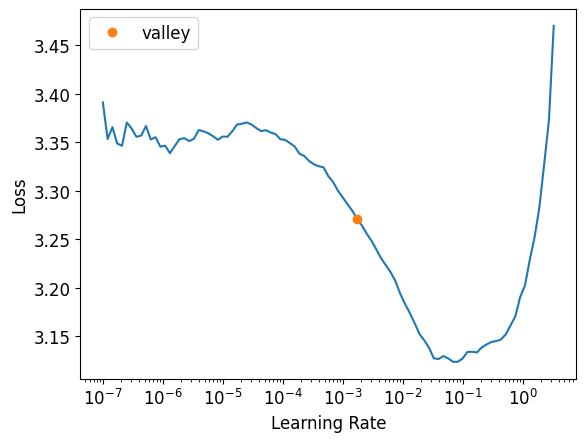

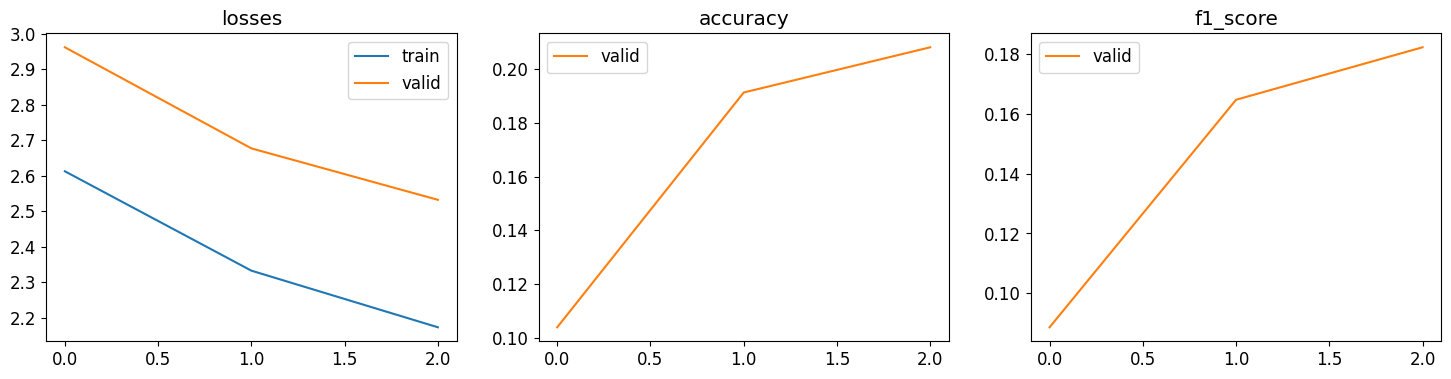

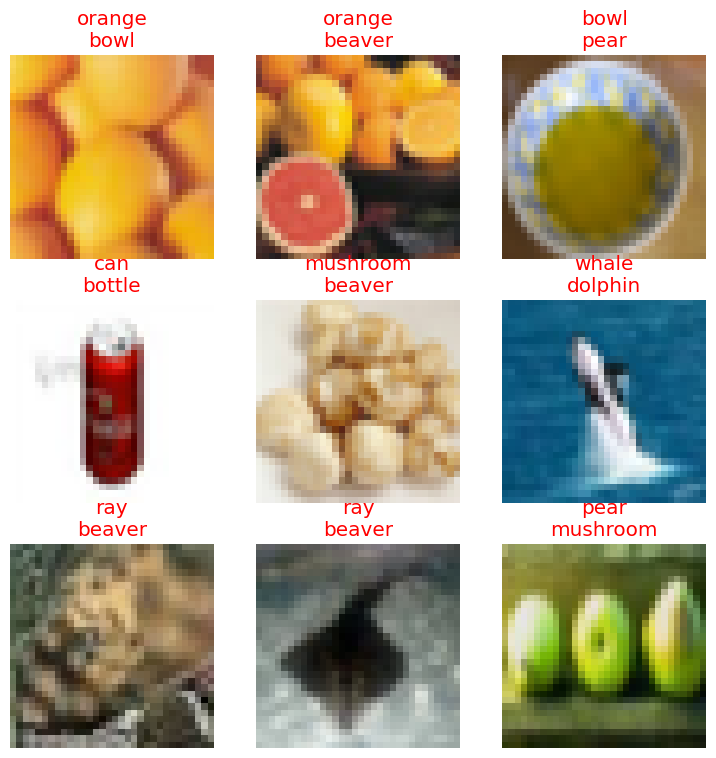

In [ ]:
#apply_init(learn.model)
#learn.opt = learn.create_opt()
lr = learn.lr_find() # Learning rate finder
print(lr[0])  # valor de learning rate encontrado
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0]) # entrenar unas pocas épocas (3)
learn.recorder.plot_metrics() # mostrar métricas en el entrenamiento
learn.show_results()

Consideraremos dos posibles valores para el learning rate: el encontrado por el learning rate finder, que se encuantra en mitad de la pendiente descendente más pronunciada y otro un poco mayor 0.01.

Por otro lado, como se comentó en el ejercicio anterior, se ha observado que usar tamaños de batch mayores perjudica a la capacidad de generalización del modelo, así que con el fin de tratar de evitar el sobreajuste probaremos esta vez con tamaños de batch igual a 16 y 32, en lugar de 32 y 64.

In [ ]:
learning_rates = [lr[0], 0.01] # posibles valores del learning rate
batch_sizes = [16, 32] # posibles valores para el tamaño de batch
epochs = 150 # número de épocas

Entrenamos el modelo para todas las combinaciones de learning rates y tamaños de batch y vemos cual es la que minimiza el valor de la función de pérdida en validación.

Se ha aumentado el número de épocas a 150, ya que haber aumentado tanto el dropout el modelo necesitará más tiempo para converger, como he podido comprobar ejecutando la celda siguiente con epochs=50: el entrenamiento acababa porque se alcanzaba el máximo de épocas pero la función de pérdida en validación seguía disminuyendo.

Learning Rate: 0.001737800776027143, Batch Size: 16


No improvement since epoch 67: early stopping


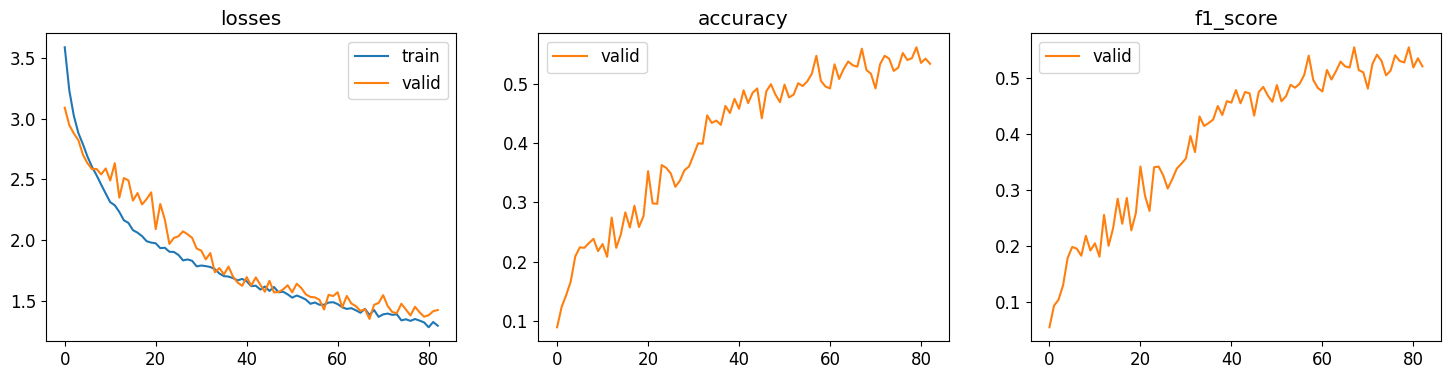

Valor mínimo de la función de pérdida en validación: 1.3499577045440674
Learning Rate: 0.001737800776027143, Batch Size: 32


No improvement since epoch 70: early stopping


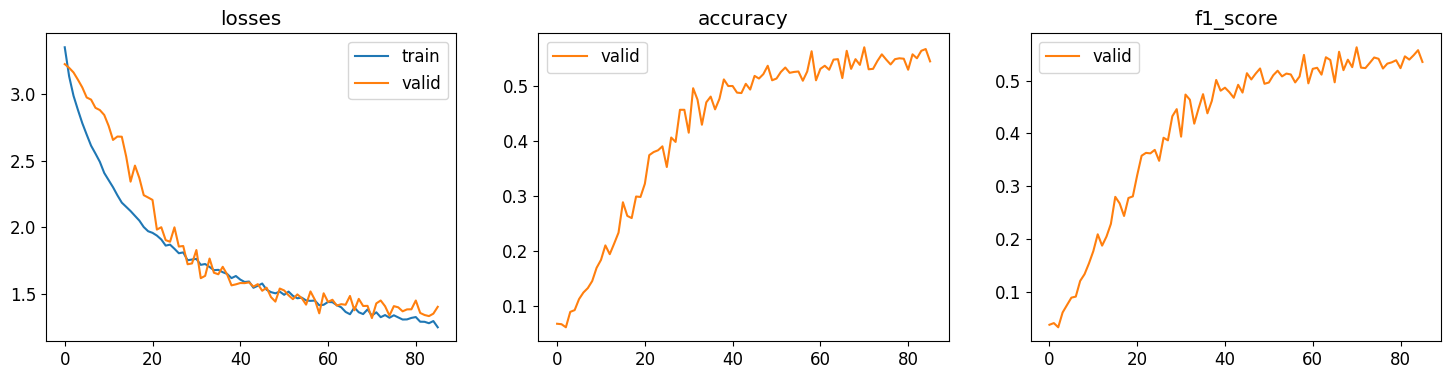

Valor mínimo de la función de pérdida en validación: 1.3185335397720337
Learning Rate: 0.01, Batch Size: 16


No improvement since epoch 61: early stopping


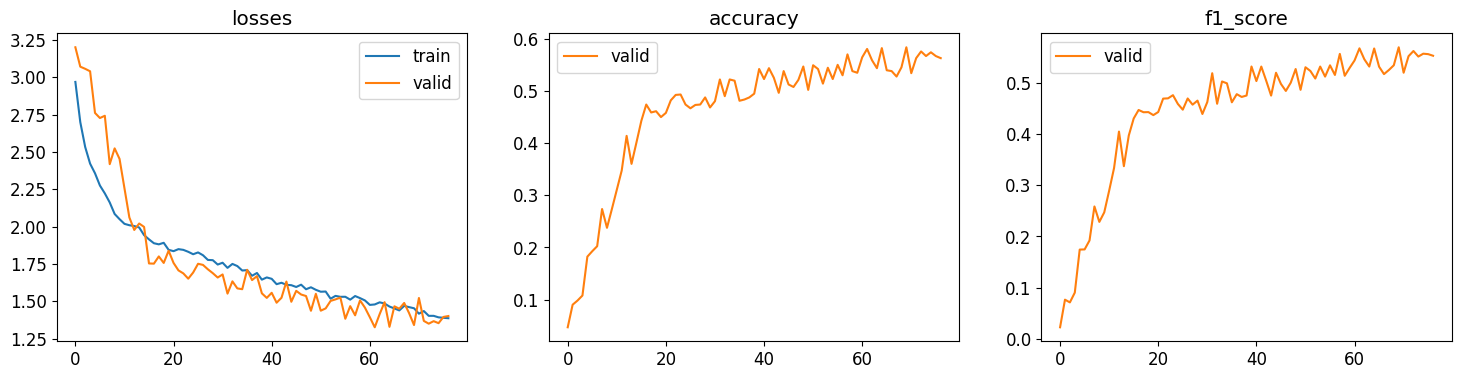

Valor mínimo de la función de pérdida en validación: 1.3252789974212646
Learning Rate: 0.01, Batch Size: 32


No improvement since epoch 90: early stopping


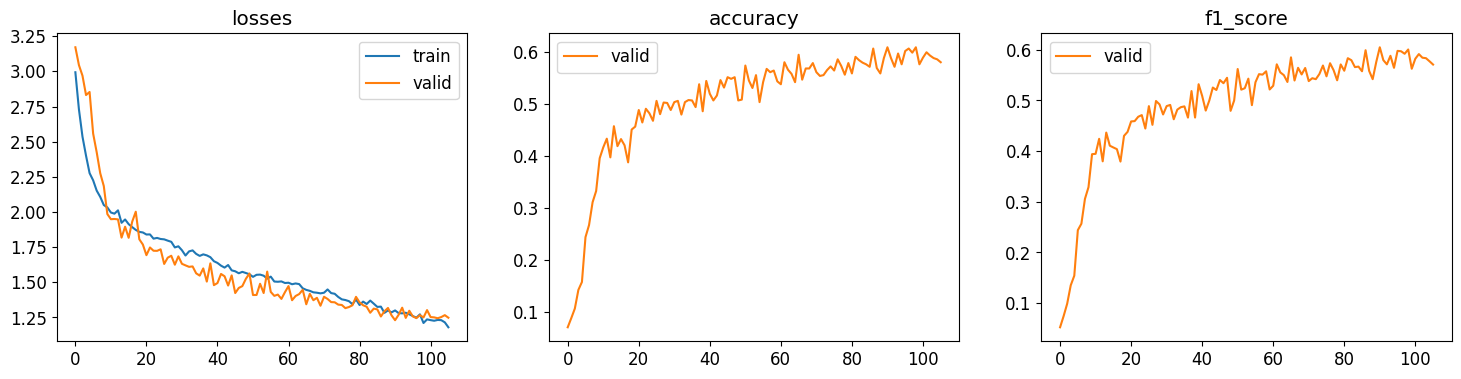

Valor mínimo de la función de pérdida en validación: 1.2307173013687134


In [ ]:
resultados = [] # lista para almacenar los resultados obtenidos con cada configuración de hiperparámetros
for lr in learning_rates:
    for bs in batch_sizes:
        print("Learning Rate: {}, Batch Size: {}".format(lr, bs))
        # Ajustar el tamaño del batch
        learn.dls.train.batch_size = bs
        learn.dls.valid.batch_size = bs

        # Reiniciar el modelo y el optimizador
        # Si se llama varias veces a fit_one_cycle se empieza a entrenar con los pesos resultantes de la llamada anterior. Por eso es
        # necesario reiniciar el modelo. También se reinicia el optimizador porque puede haberse quedado guardada información acerca
        # de los momentum u otra información residual
        apply_init(learn.model)
        learn.opt = learn.create_opt()

        # Entrenar el modelo con la política de un ciclo
        learn.fit_one_cycle(epochs, lr_max=lr)

        # Mostramos la evaluación de la función de pérdida y las métricas durante el entrenamiento
        learn.recorder.plot_metrics()

        # Recuperamos el valor mínimo de la función de pérdida (en validación) obtenido durante el entrenamiento
        min_loss = min(np.stack(learn.recorder.values)[:,1])
        print("Valor mínimo de la función de pérdida en validación: {}".format(min_loss))

        # Guardamos los resultados obtenidos
        resultados.append({"learning_rate": lr,
                        "batch_size": bs,
                        "min_loss": min_loss})


In [ ]:
best_params = min(resultados, key=lambda x: x["min_loss"])

lr_best = best_params['learning_rate']
bs_best = best_params['batch_size']
print("Mejor learning rate encontrado: {}".format(lr_best))
print("Mejor batch size encontrado: {}".format(bs_best))

Mejor learning rate encontrado: 0.01
Mejor batch size encontrado: 32


El valor mínimo de la función de pérdida en validación con lr=0.01 y bs=32 es 1.231, lo que supone una mejora respecto al modelo anterior, con el que se obtenía 1.409.

Observamos también que la diferencia entre la pérdida en validación y entrenamiento es mucho más pequeña, lo cual indica un menor grado de sobreajuste. De hecho, la pérdida en validación es incluso menor que la de entrenamiento durante la mayor parte del proceso.

Esto es debido al uso de data augmentation y dropout. El data augmentation introduce transformaciones, haciendo que las imágenes sean más difíciles de aprender y aumentando la pérdida. Además, el dropout desactiva aleatoriamente algunas neuronas durante el entrenamiento, lo que dificulta temporalmente que el modelo se ajuste a los datos. En el conjunto de validación, no se aplican estas técnicas, por lo que el modelo evalúa las imágenes "más fáciles" y utiliza toda su capacidad (sin dropout), resultando en una pérdida más baja.

## Tercer modelo (el mejor)


El modelo anterior parece estar regularizando en exceso, lo que podría estar limitando su capacidad de aprendizaje. Por ello, vamos a reducir ligeramente el dropout y la intensidad del data augmentation. El objetivo es observar si la función de pérdida en validación disminuye aún más y conseguimos un mejor rendimiento general del modelo.

Ahora, el data augmentation introducirá transformaciones de cambios de brillo y contrastes menores (se deja el valor por defecto) y disminuimos el dropout: a 0.2 en capas convolucionales y 0.4 en las densas.

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


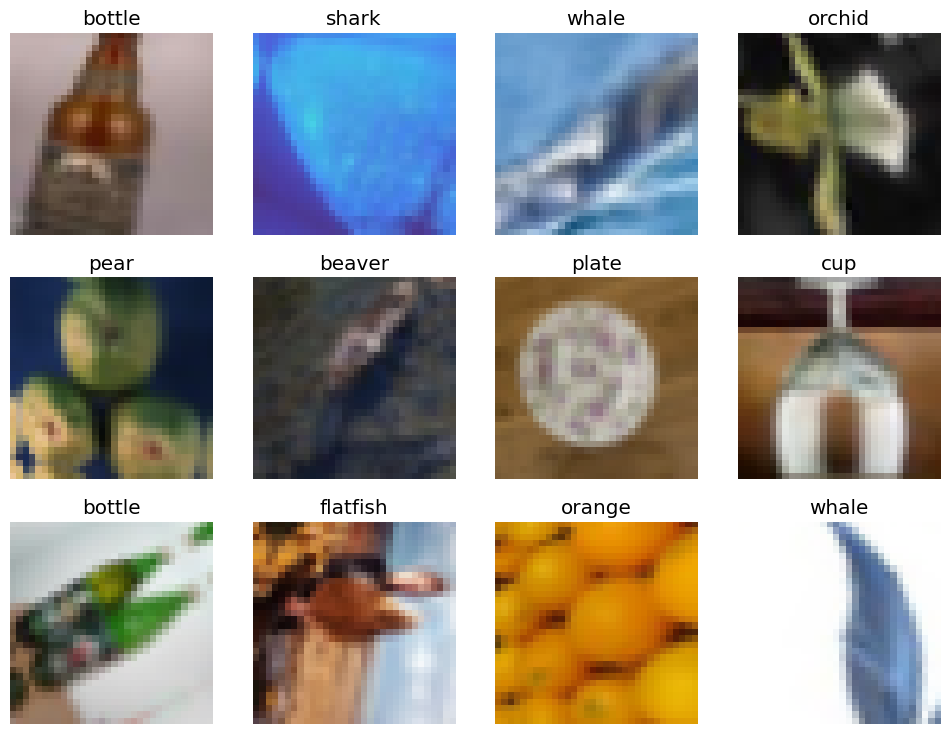

In [ ]:
# Definimos el DataBlock
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # las entradas son imágenes y las salidas categorías
    get_items=get_image_files,  # recuperar imágenes del path (imágenes del conjunto de entrenamiento)
    splitter=RandomSplitter(valid_pct=0.1, seed=42),  # separar un 10% del conjunto de entrenamiento para validación
    get_y=parent_label, # las etiquetas de las imágenes se obtienen del nombre del directorio en que se se encuentran
    batch_tfms=aug_transforms(flip_vert=True, max_rotate=30, max_zoom=1.2) + [Normalize.from_stats(mean, std)] # menos data augmentation y normalización
)
# Creamos los DataLoaders a partir del DataBlock
dl = db.dataloaders(path/'train')
#db.summary(path)

dl.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dl.train_ds))
print('Numero de ejemplos de validacion:', len(dl.valid_ds))


  **MODELO 3**

  En todas las capas convolucionales se usa un padding de 1 para mantener las mismas dimensiones de entrada que de salida y así evitar que el tamaño de la entrada disminuya muy rápidamente.

  - **Capa convolucional 2D con 32 filtros**. Tamaño entrada: 32x32x3. Tamaño salida = 32x32x32. Tamaño del kernel 3x3. Padding=1

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.2**

  - **Capa de max pooling 2x2**. Tamaño de la entrada: 32x32x32. Tamaño de la salida: 16x16x32

  - **Capa convolucional 2D con 64 filtros**. Tamaño entrada: 16x16x32. Tamaño salida = 16x16x64. Tamaño del kernel 3x3. Padding=1

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.2**

  - **Capa de max pooling 2x2**. Tamaño de la entrada: 16x16x64. Tamaño de la salida: 8x8x64

  - **Capa convolucional 2D con 128 filtros**. Tamaño entrada: 8x8x64. Tamaño salida = 8x8x128. Tamaño del kernel 3x3. Padding=1

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.2**

  - **Capa de max pooling 2x2**. Tamaño de la entrada: 8x8x128. Tamaño de la salida: 4x4x128


  - **Capa densa**. Tamaño entrada: 4x4x128=2048. Tamaño salida: 512

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.4**

  - **Capa densa**. Tamaño entrada: 512. Tamaño salida: 128

  - **Batch Normalization**

  - **ReLU**

  - **Dropout 0.4**

  - **Capa densa de salida**. Tamaño entrada: 128. Tamaño salida: 25

  - **Solftmax**

In [ ]:
import torch.nn as nn

BaseNetMejorado = nn.Sequential(
    # Primera capa convolucional | in 32x32
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.MaxPool2d(kernel_size=(2, 2)), #| in 32x32 | out 16x16

    # Segunda capa convolucional  | in 16x16
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.MaxPool2d(kernel_size=(2, 2)),  #| in 16x16 | out 8x8

    # Tercera capa convolucional | in 8x8 | out 8x8
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.MaxPool2d(kernel_size=(2, 2)),  #| in 8x8 | out 4x4

    # Flatten de la salida de las capas convolucionales
    nn.Flatten(),

    # Primera capa densa con Dropout
    nn.Linear(in_features=2048, out_features=512),  # Aumentar el número de unidades
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.4),  # Reducir un poco el dropout

    # Capa densa adicional con Dropout
    nn.Linear(in_features=512, out_features=128),  # Aumentar unidades
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(p=0.4),  # Dropout para evitar sobreajuste

    # Capa de salida
    nn.Linear(in_features=128, out_features=25)  # 25 clases de salida
)


**Cálculo del número de parámetros**

Recordamos que las capas de activación y de pooling no tienen parámetros.
Las capas de dropout tampoco.
Las de batch normalization sí que introducen parámetros al modelo. Hay dos vectores que se deben de aprender: el vector de desplazamiento y el vector de escala. La media y varianza no se aprenden directamente, sino que se calculan durante el entrenamiento. Recordemos que se normaliza cada canal por separado, así que estos vectores tendrán tantos elementos como canales tenga la entrada. De esta forma, si la entrada tiene n canales, el número total de parámetros a aprender de la capa de batch normalization será 2*n.

En el caso de las capas de batch normalization que hay después de las capas densas es diferente, puesto que la entrada está aplanada. En este caso el número de parámetros sería 2 multiplicado por el tamaño de la entrada.



- Primera capa convolucional: (3x3x3 + 1) x 32 = 896
  - 3x3x3 porque el kernel es 9x9 y la señal de entrada tiene 3 canales
  - +1 por el bias
  - el resultado se multiplica por 32 porque se aplican 5 filtros
  - Contribución de la capa al número de parámetros: 0.0007%

- Capa de Batch Normalization: 32x2 = 64
  - 32 porque la entrada tiene 32 canales
  - 2 porque se aprenden dos vectores: el de escala y el de desplazamiento
  - Contribución de la capa al número de parámetros: 0.0001%

- Segunda capa convolucional: (3x3x32 + 1) x 64 = 18496
  - 3x3x32 porque el kernel es 3x3 y la entrada tiene 32 canales
  - +1 por el bias
  - el resultado se multiplica por 64 porque se aplican 64 filtros
  - Contribución de la capa al número de parámetros: 0.0152%

- Capa de Batch Normalization: 64x2 = 128
  - 64 porque la entrada tiene 64 canales
  - 2 porque se aprenden dos vectores: el de escala y el de desplazamiento
  - Contribución de la capa al número de parámetros: 0.0001%

- Tercera capa convolucional: (3x3x64 + 1) x 128 = 73856
  - 3x3x64 porque el kernel es 3x3 y la entrada tiene 64 canales
  - +1 por el bias
  - el resultado se multiplica por 128 porque se aplican 128 filtros
  - Contribución de la capa al número de parámetros: 0.0609%

- Capa de Batch Normalization: 128x2 = 256
  - 128 porque la entrada tiene 128 canales
  - 2 porque se aprenden dos vectores: el de escala y el de desplazamiento
  - Contribución de la capa al número de parámetros: 0.0002%

- Primera capa densa: (2048x512) + 512 = 1049088: número de entradas x número de neuronas de la capa + 1 bias por neurona
  - Contribución de la capa al número de pesos: 0.8649%

- Capa de Batch Normalization: 512x2 = 1024
  - 512 porque la entrada es de tamaño 512
  - 2 porque se aprenden dos vectores: el de escala y el de desplazamiento
  - Contribución de la capa al número de parámetros: 0.0008%

- Segunda capa densa: (512x128) + 128 = 65664: número de entradas x número de neuronas de la capa + 1 bias por neurona
  - Contribución de la capa al número de parámetros: 0.0541%

- Capa de Batch Normalization: 128x2 = 256
  - 128 porque la entrada es de tamaño 128
  - 2 porque se aprenden dos vectores: el de escala y el de desplazamiento
  - Contribución de la capa al número de parámetros: 0.0002%

- Tercera capa densa: (128x25) + 25 = 3225: número de entradas x número de neuronas de la capa + 1 bias por neurona
  - Contribución de la capa al número de parámetros: 0.0027%

  Número total de parámetros = 896 + 64 + 18496 + 128 + 73856 + 256 + 1049088 + 1024 + 65664 + 256 + 3225 = 1212953

Vemos que, como en el modelo del ejercicio anterior, la mayor parte de los parámetros se encuentran en las capas densas. Aproximadamente el 92% en este caso.

A continuación creamos el learner.

In [ ]:
learn = Learner(dl, # dataloader con los datos de entrenamiento
                BaseNetMejorado,  # modelo creado previamente
                loss_func=CrossEntropyLossFlat(), # indicamos que usamos la entropía cruzada como función de pérdida
                opt_func=Adam, # indicamos que queremos usar el optimizador Adam, aunque no sería necesario ya que este es el optimizador por defecto
                metrics=[accuracy, F1Score(average='weighted')],  # usamos como métricas accuracy y f1-score
                cbs=[EarlyStoppingCallback(patience=20)])  # early stopping con paciencia 5
learn.summary()

Sequential (Input shape: 64 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 32 x 32   
Conv2d                                    896        True      
BatchNorm2d                               64         True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                     64 x 32 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 64 x 16 x 16   
Conv2d                                    18496      True      
BatchNorm2d                               128        True      
ReLU                                                           
Dropout                                                        
_____________________________________

Ahora usamos el learning rate finder para encontrar un learning rate adecuado.



0.0006918309954926372


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

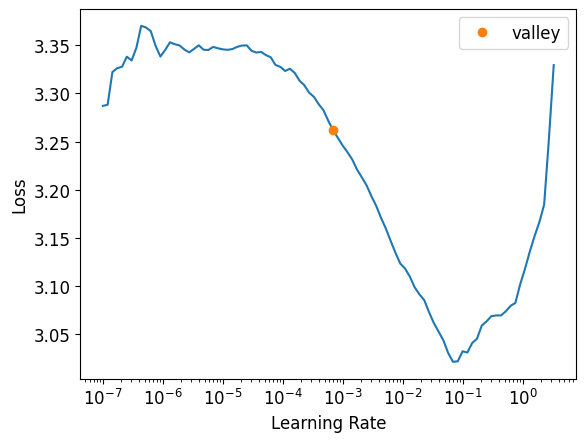

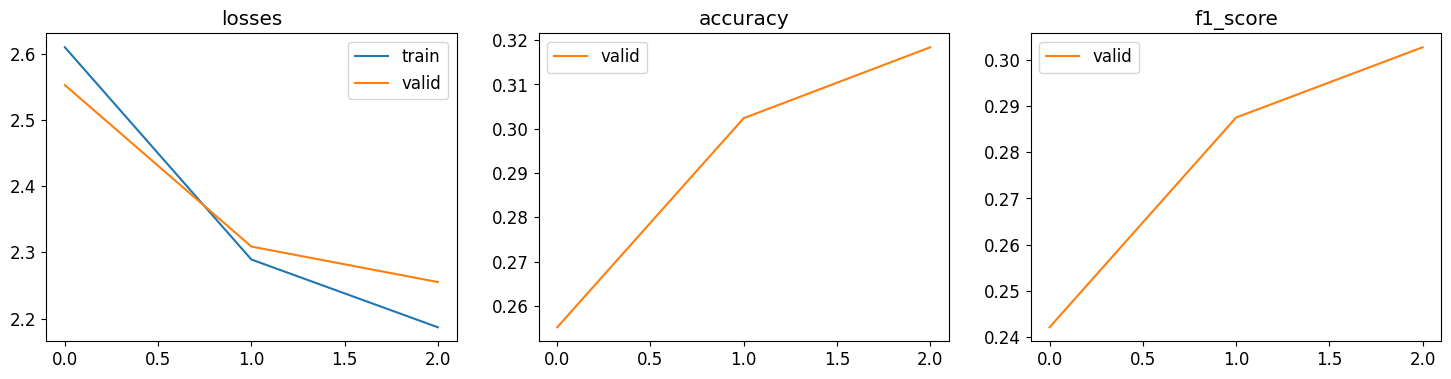

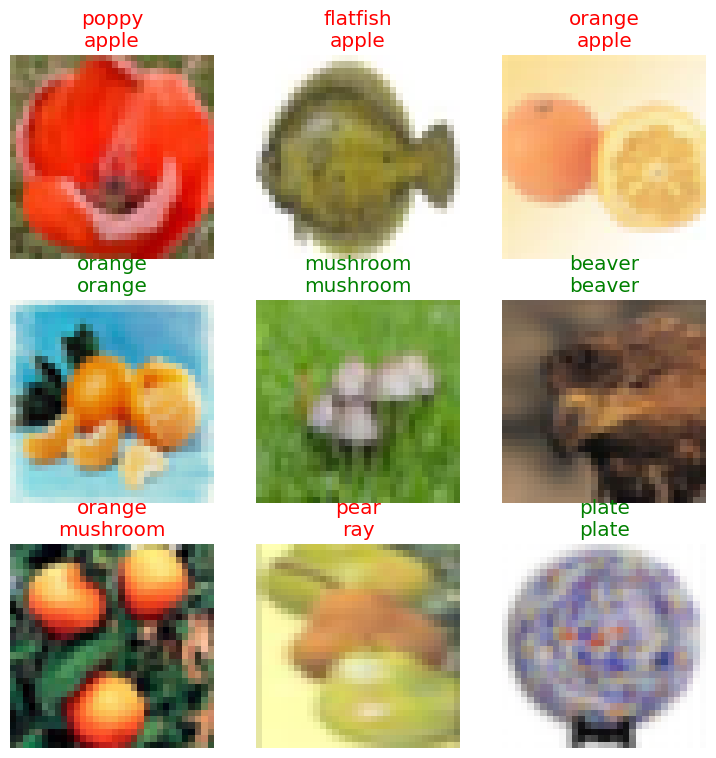

In [ ]:
#apply_init(learn.model)
#learn.opt = learn.create_opt()
lr = learn.lr_find() # Learning rate finder
print(lr[0])  # valor de learning rate encontrado
learn.fit_one_cycle(n_epoch=3, lr_max=lr[0]) # entrenar unas pocas épocas (3)
learn.recorder.plot_metrics() # mostrar métricas en el entrenamiento
learn.show_results()

Como siempre, contemplaremos varios valores para el learning rate. En este caso el encontrado por el learning rate finder y 0.01. Ambos parecen valores adecuados, ya que se encuentran en el tramos de pendiente descendente

Probaremos también con batch sizes de 16 y 32.

A continuación entrenamos el modelo para todas las combinaciones de learning rates y tamaños de batch y vemos cual es la que minimiza el valor de la función de pérdida en validación.

**Learning rate = 0.000692** (el encontrado por el learning rate finder)

**Batch size = 16**

No improvement since epoch 109: early stopping


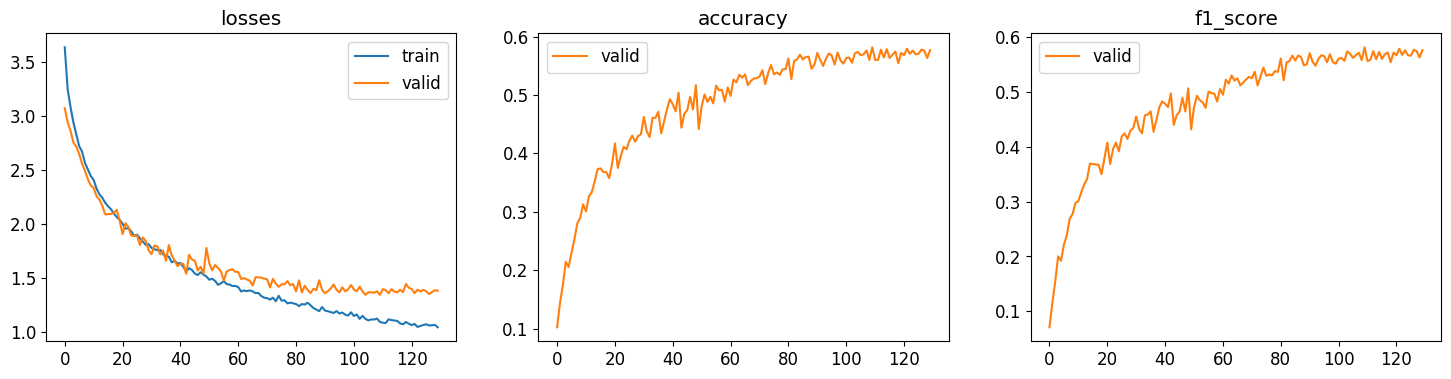

In [ ]:
learn.dls.train.batch_size = 16
learn.dls.valid.batch_size = 16

apply_init(learn.model)
learn.opt = learn.create_opt()

learn.fit_one_cycle(150, lr_max=lr[0])

learn.recorder.plot_metrics()

El valor mínimo de la función de pérdida en validación es 1.340482

**Learning rate = 0.01**

**Batch size = 16**

No improvement since epoch 100: early stopping


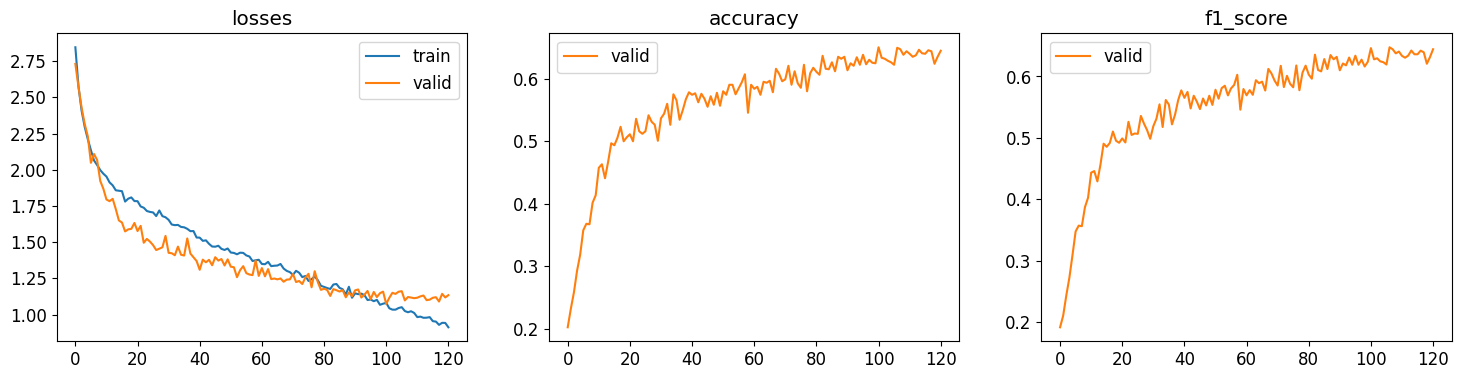

In [ ]:
learn.dls.train.batch_size = 16
learn.dls.valid.batch_size = 16

apply_init(learn.model)
learn.opt = learn.create_opt()

learn.fit_one_cycle(150, lr_max=0.01)

learn.recorder.plot_metrics()

El valor mínimo de la función de pérdida en validación es 1.073393

**Learning rate = 0.000692** (el encontrado por el learning rate finder)

**Batch size = 32**

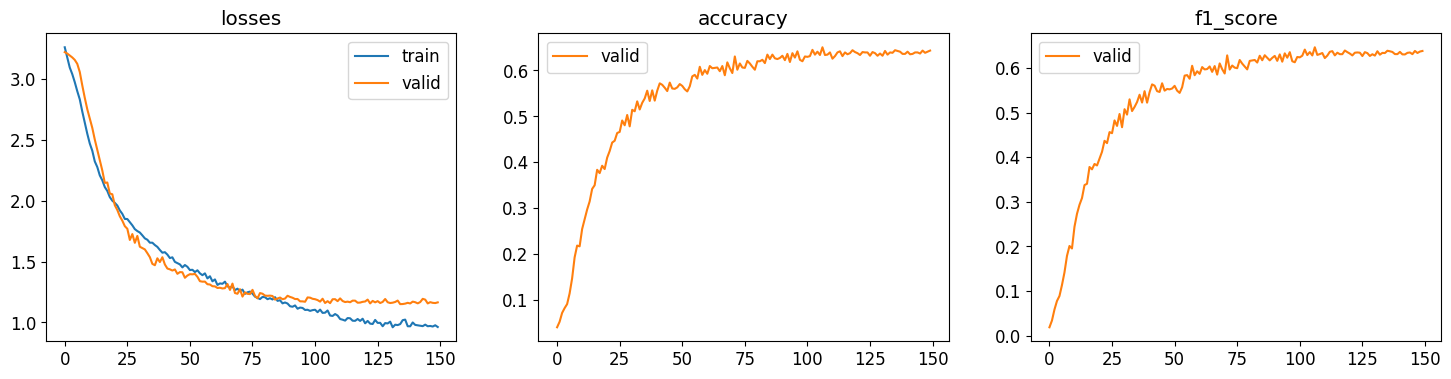

In [ ]:
learn.dls.train.batch_size = 32
learn.dls.valid.batch_size = 32

apply_init(learn.model)
learn.opt = learn.create_opt()

learn.fit_one_cycle(150, lr_max=lr[0])

learn.recorder.plot_metrics()

El valor mínimo de la función de pérdida en validación es 1.150471 (época 134). En este caso el entrenamiento ha parado porque se ha alcanzado el número máximo de épocas, aunque de todas formas no parecía que fuera a disminuir mucho más la función de pérdida, llevaba 15 épocas sin mejorar.

**Learning rate = 0.01**

**Batch size = 32**

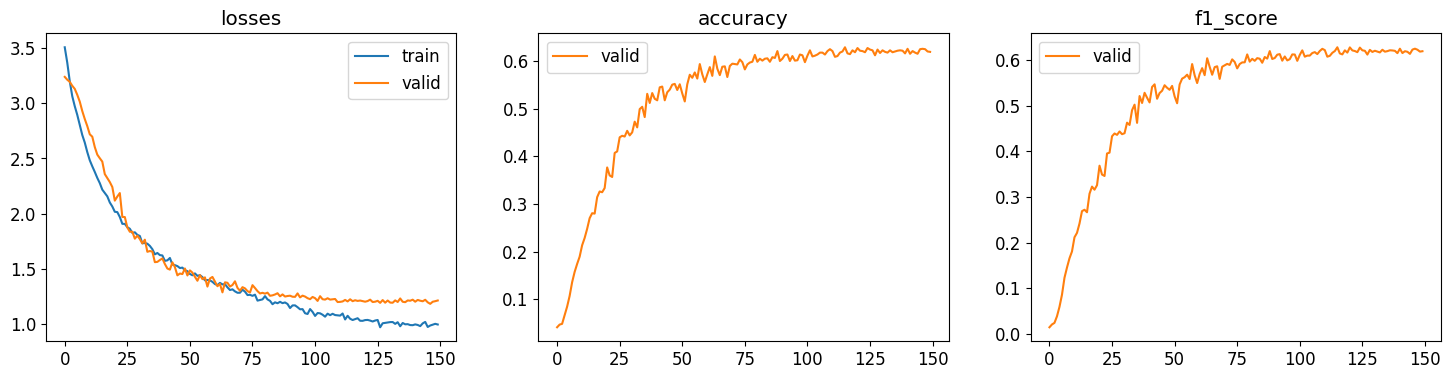

In [ ]:
learn.dls.train.batch_size = 32
learn.dls.valid.batch_size = 32

apply_init(learn.model)
learn.opt = learn.create_opt()

learn.fit_one_cycle(150, 0.01)

learn.recorder.plot_metrics()

El valor mínimo de la función de pérdida en validación es 1.192294 (época 131).

Los mejores hipérparametros son entonces learning rate=0.01 y batch size=16.
Este modelo con estos hiperparámetros será nuestro modelo final.
Con estos parámetros se obtiene 1.07 como valor mínimo de la función de pérdida en validación. Esto supone una mejora considerable con respecto al primer modelo probado en este ejercicio, con el que se obtenía 1.409, y una mejora aún mayor con el modelo del ejercicio anterior (2.03)

In [ ]:
best_bs = 16
best_lr = 0.01

No improvement since epoch 125: early stopping


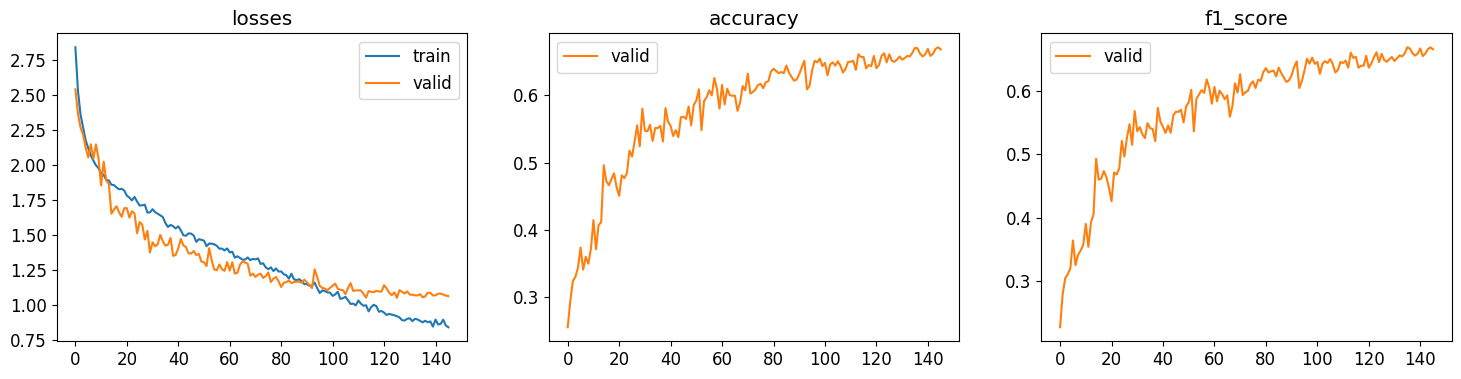

In [ ]:
learn.dls.train.batch_size = best_bs
learn.dls.valid.batch_size = best_bs

apply_init(learn.model)
learn.opt = learn.create_opt()

learn.fit_one_cycle(150, lr_max=best_lr)

learn.recorder.plot_metrics()

Podemos ver que la forma de la curva de la función de pérdida es bastante similar a la del segundo modelo. También en este caso, durante gran parte del entrenamiento, la pérdida de validación es menor que la de entrenamiento, debido al dropout y al data augmentation. Pero con este modelo disminuye el valor mínimo de la función de pérdida en validación, lo que nos indica que el modelo ha mejorado su capacidad para generalizar a datos no vistos.

In [ ]:
dl_train = dl.train
dl_valid = dl.valid

**Resultados en validación**

Número de ejemplos de validación: 1250
Accuracy:  66.8 %


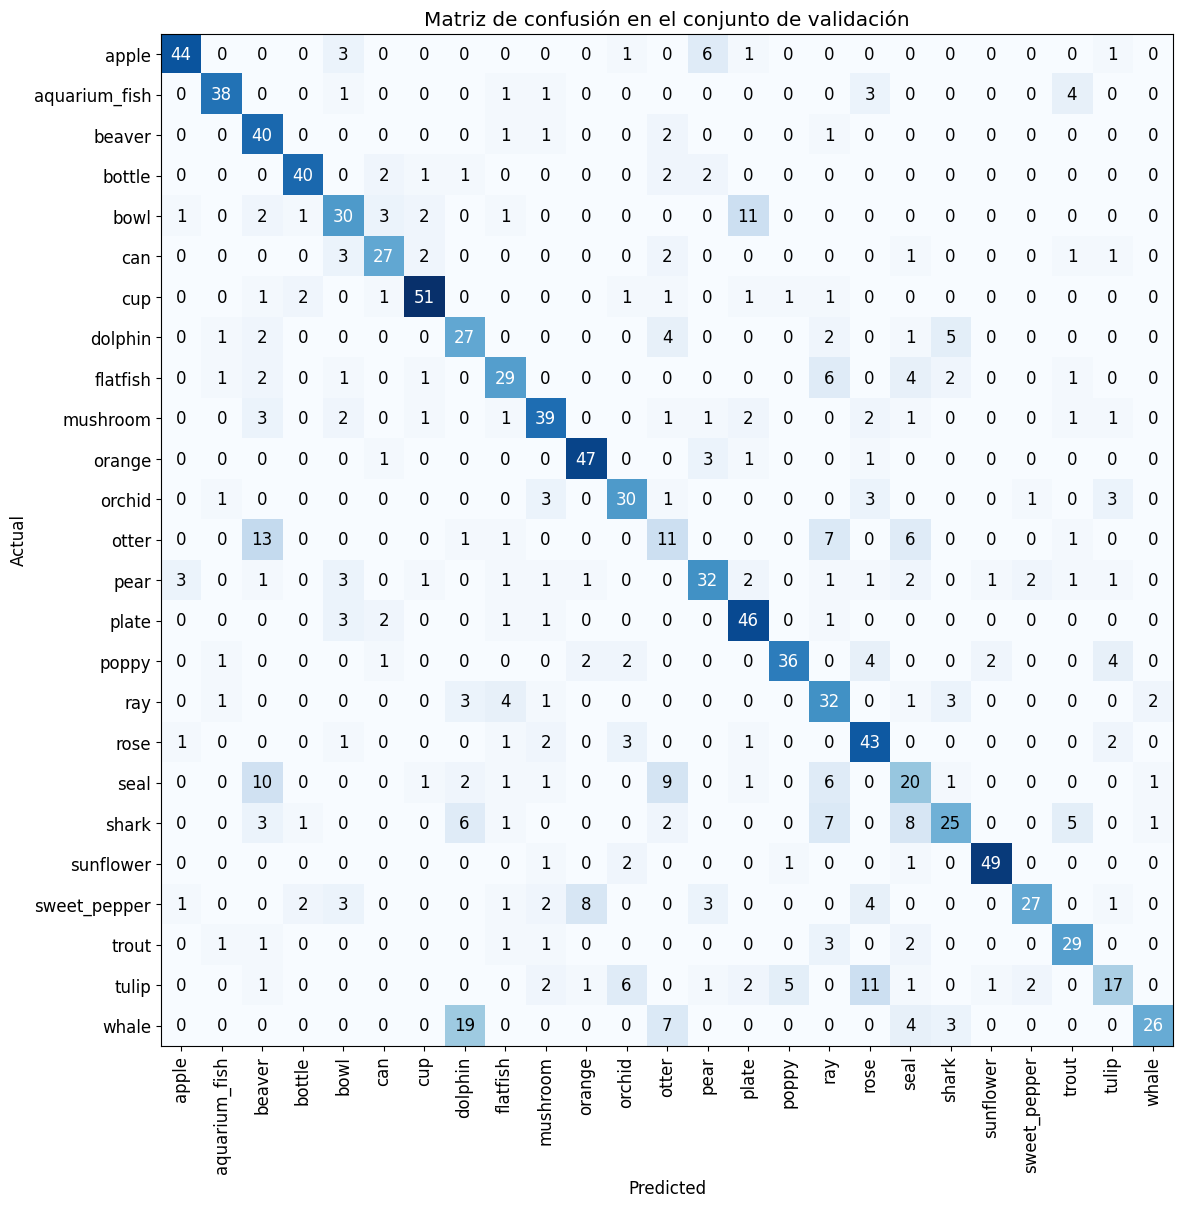

In [ ]:
# Realizamos las predicciones sobre el conjunto de validación y calculamos el accuracy y la matriz de confusión
preds_valid, targs_valid, _ = learn.get_preds(dl=dl_valid, with_decoded=True)
acc_valid = accuracy(preds_valid, targs_valid)

interp_valid = ClassificationInterpretation.from_learner(learn, 1, dl_valid)
cm_valid = interp_valid.confusion_matrix()
interp_valid.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en el conjunto de validación')

print('Número de ejemplos de validación:', np.sum(cm_valid))
print('Accuracy: ', round(float(acc_valid)*100, 4), '%')

Se ha obtenido una accuracy del 66.8%. Lo que supone un incremento de casi el 27% con respecto al modelo del primer ejercicio.

Al igual que antes, hay clases que el modelo distingue mejor que otras.
Fijándonos en los mismos ejemplos que vimos en el apartado anterior, en cuanto a las naranjas, esta vez clasifica bien el 88.7% (47 de las 53), mientras que antes era solo 62.5%. El tulipán sigue siendo confundido con otras flores como la rosa, las amapolas o las orquídeas, de forma que solo se consiguen clasificar bien el 34% (17 de 50). Esto está bastante por debajo que la accuracy general, pero al menos mejora considerablemente el 7.5% del modelo anterior.

En general el modelo distingue mucho mejor, como es de esperar, las clases que guardan menos similitud con otras clases, como hemos visto que es el caso de la naranja o de otras clases como las copas o los girasoles. Mientras que las clases que son parecidas entre sí, como por ejemplo los castores y las nutrias son confundidas frecuentemente. Lo mismo pasa con las ballenas, que son clasificadas incorrectamente como delfines en muchas ocasiones o los tulipanes, que son confundidos con otros tipos de flores.

**Resultados en entrenamiento**

Número de ejemplos de validación: 11250
Accuracy:  73.2889 %


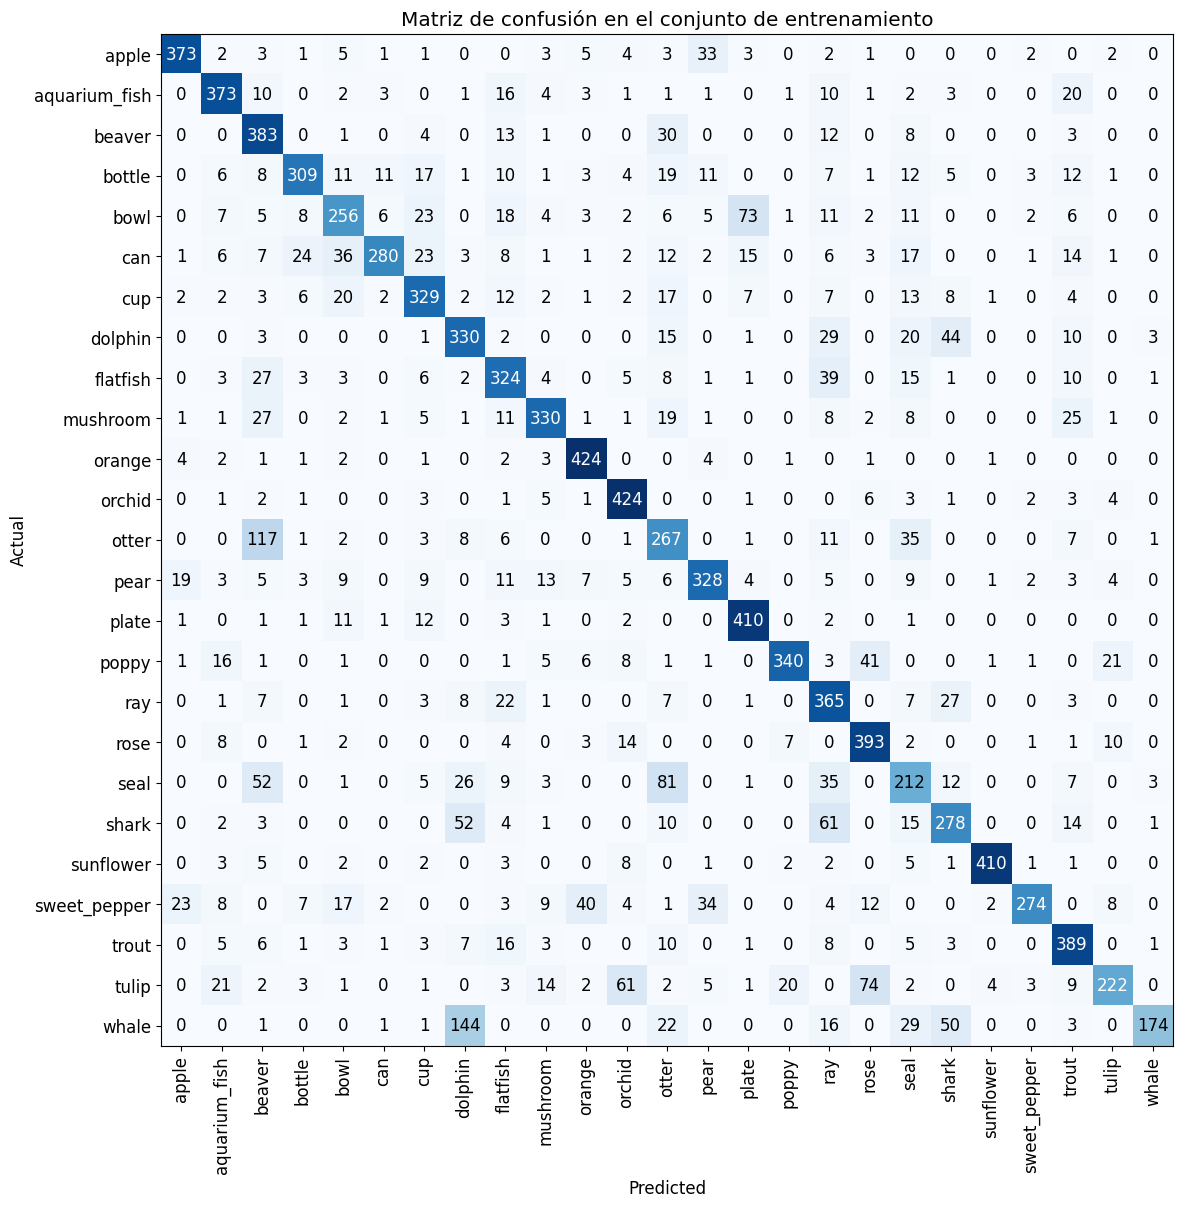

In [ ]:
# Realizamos las predicciones sobre el conjunto de entrenamiento y calculamos el accuracy y la matriz de confusión
preds_train, targs_train, _ = learn.get_preds(dl=dl_train, with_decoded=True)
acc_train = accuracy(preds_train, targs_train)

interp_train = ClassificationInterpretation.from_learner(learn, 1, dl_train)
cm_train = interp_train.confusion_matrix()
interp_train.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en el conjunto de entrenamiento')

print('Número de ejemplos de validación:', np.sum(cm_train))
print('Accuracy: ', round(float(acc_train)*100, 4), '%')

Podemos ver que en conjunto de entrenamiento se obtienen un 72.2889% de accuracy. Este aumento respecto al conjunto de validación se debe a que se están haciendo las predicciones sobre ejemplos que ya ha visto el modelo durante el entrenamiento.

También podemos observar que, al igual que en validación, el modelo clasifica mejor las clases que son más diferentes entre sí, mientras que tiende a clasificar erróneamente las que tienen características más similares. Si el modelo no estuviera regularizado, probablemente esto no sucedería, ya que un modelo con un sobreajuste muy grande memorizaría los datos de entrenamiento. En este caso, clasificaría correctamente incluso las clases similares en el conjunto de entrenamiento, pero tendría un rendimiento mucho peor en los datos de validación

**Resultados en test**

Es importante normalizar los datos de test de la misma forma que los datos de entrenamiento, para no caer en data snooping. Esto lo hace automáticamente fastai al crear el data loader para el conjunto de test de la siguiente manera.

Número de ejemplos de test: 2500
Accuracy:  66.28 %


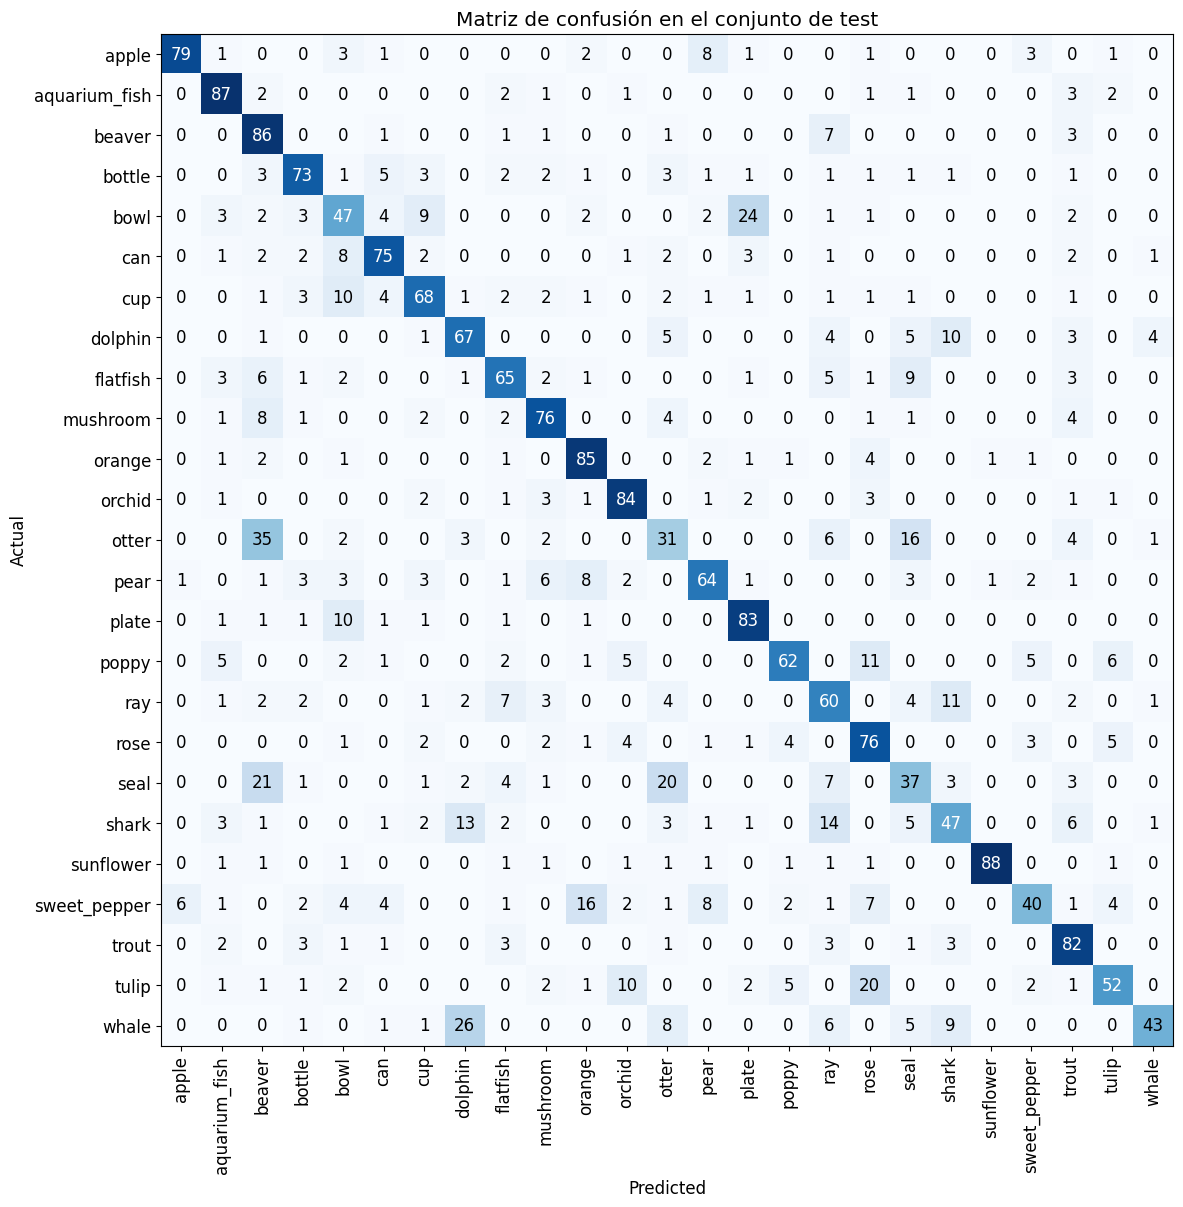

In [ ]:
# Creamos data loader para el conjunto de test
test_files = [fn for fn in sorted((path/'test').glob('**/*')) if fn.is_file()]

dl_test = learn.dls.test_dl(test_files,with_labels=True)

# Realizamos las predicciones sobre el conjunto de test y calculamos el accuracy y la matriz de confusión
preds_test, targs_test, _ = learn.get_preds(dl=dl_test, with_decoded=True)
acc_test = accuracy(preds_test, targs_test)

interp_test = ClassificationInterpretation.from_learner(learn, 1, dl_test)
cm_test = interp_test.confusion_matrix()
interp_test.plot_confusion_matrix(figsize=(12, 12),title='Matriz de confusión en el conjunto de test')

print('Número de ejemplos de test:', np.sum(cm_test))
print('Accuracy: ', round(float(acc_test)*100, 4), '%')

Finalmente, en test obtenemos un 66.28% de accuracy, lo que supone una mejora de casi un 27% con respecto al modelo del ejercicio anterior. Los resultados son muy similares a los de validación, ya que los datos de test tampoco han sido vistos por el modelo durante el entrenamiento.